**Air Dataset PMDD**
---

In [ ]:
from google.colab import drive
import pandas as pd
#rive.mount('/content/drive')
df = pd.read_csv("/content/air_2019.csv")
df

,Unnamed: 0,Year,Month,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,origin_lat,origin_long,dest_lat,dest_long,total_delay
0,0,2000,7,1,830,926,56.0,224,47.619856,-117.533843,47.448982,-122.309313,0
1,1,1999,1,6,1030,1130,60.0,224,47.619856,-117.533843,47.448982,-122.309313,1
2,2,2000,5,1,1720,1815,55.0,224,47.619856,-117.533843,47.448982,-122.309313,1
3,3,1999,4,3,1315,1410,55.0,224,47.619856,-117.533843,47.448982,-122.309313,0
4,4,1999,10,5,700,758,58.0,224,47.619856,-117.533843,47.448982,-122.309313,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,9995,2000,10,7,826,910,44.0,183,64.512202,-165.445246,66.884677,-162.598550,0
9985,9996,1999,2,1,1010,1047,37.0,95,58.354962,-134.576276,57.047138,-135.361598,1
9986,9997,1999,7,5,1440,1508,28.0,45,18.337306,-64.973361,17.701889,-64.798556,0
9987,9998,2000,1,5,1017,1053,36.0,82,55.355569,-131.713740,56.484326,-132.369824,0


In [ ]:
# ============================================================
# AIR DATASET – Random Forest Classification (Single Cell)
# Reads CSV → cleans/engineers → selects feature_columns → trains RF
# Target: total_delay (binary)
# ============================================================

# === Import Libraries ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# ============================================================
# Step 0: Load Dataset
# ============================================================

df = pd.read_csv("/content/air_2019.csv")
df.columns = [c.strip() for c in df.columns]

# Drop index-like column if exists (your screenshot shows Unnamed: 0)
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Drop missing values
df = df.dropna().reset_index(drop=True)


# ============================================================
# Step 1: Transformation (Time Feature Engineering)
# Convert CRSDepTime / CRSArrTime from HHMM -> minutes since midnight
# ============================================================

def hhmm_to_minutes(x):
    x = int(x)
    hh = x // 100
    mm = x % 100
    if mm >= 60:
        mm = 59
    return hh * 60 + mm

# create *_min columns
for col in ["CRSDepTime", "CRSArrTime"]:
    if col in df.columns:
        df[col + "_min"] = df[col].apply(hhmm_to_minutes)

# Drop original HHMM time columns after creating engineered features
drop_time_cols = [c for c in ["CRSDepTime", "CRSArrTime"] if c in df.columns]
if len(drop_time_cols) > 0:
    df = df.drop(columns=drop_time_cols)


# ============================================================
# Step 2: Define feature_columns and Target
# ============================================================

feature_columns = [
    "Year",
    "Month",
    "DayOfWeek",
    "CRSElapsedTime",
    "Distance",
    "origin_lat",
    "origin_long",
    "dest_lat",
    "dest_long",
    "CRSDepTime_min",     # engineered feature
    # If you also want arrival time, add this (only if created):
    # "CRSArrTime_min",
]

target_col = "total_delay"

# Keep only columns that actually exist (prevents errors if one is missing)
feature_columns = [c for c in feature_columns if c in df.columns]


# ============================================================
# Step 3: Select Features (X) and Target (y)
# ============================================================

X = df[feature_columns].copy()
y = df[target_col].astype(int)

# Force numeric if any column becomes object due to parsing
for c in feature_columns:
    if X[c].dtype == "object":
        X[c] = pd.to_numeric(X[c], errors="coerce")

# Drop any new NaNs created by coercion (align X and y)
mask = X.notna().all(axis=1)
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)


# ============================================================
# Step 4: Train–Test Split
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


# ============================================================
# Step 5: Feature Scaling (Optional for RF, kept for same pipeline format)
# ============================================================

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


# ============================================================
# Step 6: Build Random Forest Model
# ============================================================

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)


# ============================================================
# Step 7: Train Model
# ============================================================

rf.fit(X_train, y_train)


# ============================================================
# Step 8: Evaluate Model
# ============================================================

y_pred = rf.predict(X_test)

print("\n✅ Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("✅ Accuracy:", accuracy_score(y_test, y_pred))



✅ Confusion Matrix:
[[1629  258]
 [ 898  212]]

✅ Classification Report:
              precision    recall  f1-score   support

           0     0.6446    0.8633    0.7381      1887
           1     0.4511    0.1910    0.2684      1110

    accuracy                         0.6143      2997
   macro avg     0.5479    0.5271    0.5032      2997
weighted avg     0.5729    0.6143    0.5641      2997

✅ Accuracy: 0.614280947614281


In [ ]:
X.columns


Index(['Year', 'Month', 'DayOfWeek', 'CRSElapsedTime', 'Distance',
       'origin_lat', 'origin_long', 'dest_lat', 'dest_long', 'CRSDepTime_min'],
      dtype='object')

In [ ]:
df['total_delay'].value_counts()

,count
total_delay,
0,6290
1,3699


In [ ]:
df.to_csv("drift.csv")

In [ ]:
df

,Year,Month,DayOfWeek,CRSElapsedTime,Distance,origin_lat,origin_long,dest_lat,dest_long,total_delay,CRSDepTime_min,CRSArrTime_min
0,2000,7,1,56.0,224,47.619856,-117.533843,47.448982,-122.309313,0,510,566
1,1999,1,6,60.0,224,47.619856,-117.533843,47.448982,-122.309313,1,630,690
2,2000,5,1,55.0,224,47.619856,-117.533843,47.448982,-122.309313,1,1040,1095
3,1999,4,3,55.0,224,47.619856,-117.533843,47.448982,-122.309313,0,795,850
4,1999,10,5,58.0,224,47.619856,-117.533843,47.448982,-122.309313,0,420,478
...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2000,10,7,44.0,183,64.512202,-165.445246,66.884677,-162.598550,0,506,550
9985,1999,2,1,37.0,95,58.354962,-134.576276,57.047138,-135.361598,1,610,647
9986,1999,7,5,28.0,45,18.337306,-64.973361,17.701889,-64.798556,0,880,908
9987,2000,1,5,36.0,82,55.355569,-131.713740,56.484326,-132.369824,0,617,653


**Drift Injection**
---

In [ ]:
df

,Year,Month,DayOfWeek,CRSElapsedTime,Distance,origin_lat,origin_long,dest_lat,dest_long,total_delay,CRSDepTime_min,CRSArrTime_min
0,2000,7,1,56.0,224,47.619856,-117.533843,47.448982,-122.309313,0,510,566
1,1999,1,6,60.0,224,47.619856,-117.533843,47.448982,-122.309313,1,630,690
2,2000,5,1,55.0,224,47.619856,-117.533843,47.448982,-122.309313,1,1040,1095
3,1999,4,3,55.0,224,47.619856,-117.533843,47.448982,-122.309313,0,795,850
4,1999,10,5,58.0,224,47.619856,-117.533843,47.448982,-122.309313,0,420,478
...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2000,10,7,44.0,183,64.512202,-165.445246,66.884677,-162.598550,0,506,550
9985,1999,2,1,37.0,95,58.354962,-134.576276,57.047138,-135.361598,1,610,647
9986,1999,7,5,28.0,45,18.337306,-64.973361,17.701889,-64.798556,0,880,908
9987,2000,1,5,36.0,82,55.355569,-131.713740,56.484326,-132.369824,0,617,653


In [ ]:
import pandas as pd
import numpy as np

# ============================================================
# AIR DATASET LOADER (FIXED: y is NOT last column)
# - Loads air_2019.csv
# - Creates CRSDepTime_min (HHMM -> minutes)
# - Uses explicit feature_columns + target_col
# ============================================================

# ---------- IO ----------
def load_data(path):
    """
    AIR loader:
    - y = total_delay (NOT last column)
    - X = selected AIR features (with engineered CRSDepTime_min)
    """
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]

    # Drop index-like column if exists
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    # Drop missing values
    df = df.dropna().reset_index(drop=True)

    # ---- Time feature engineering: CRSDepTime HHMM -> minutes ----
    def hhmm_to_minutes(x):
        x = int(x)
        hh = x // 100
        mm = x % 100
        if mm >= 60:
            mm = 59
        return hh * 60 + mm

    if "CRSDepTime" in df.columns:
        df["CRSDepTime_min"] = df["CRSDepTime"].apply(hhmm_to_minutes)
        df = df.drop(columns=["CRSDepTime"])

    # (Optional) If you ever want arrival time too, keep this block:
    # if "CRSArrTime" in df.columns:
    #     df["CRSArrTime_min"] = df["CRSArrTime"].apply(hhmm_to_minutes)
    #     df = df.drop(columns=["CRSArrTime"])

    # ---- Explicit AIR feature columns + target ----
    feature_columns = [
        "Year",
        "Month",
        "DayOfWeek",
        "CRSElapsedTime",
        "Distance",
        "origin_lat",
        "origin_long",
        "dest_lat",
        "dest_long",
        "CRSDepTime_min"
    ]
    target_col = "total_delay"

    # Keep only columns that exist (safety)
    feature_columns = [c for c in feature_columns if c in df.columns]

    # Build X and y
    X = df[feature_columns].copy()
    y = df[target_col].copy()

    # Force y to int (binary)
    y = y.astype(int)

    # Force numeric for X
    for c in feature_columns:
        if X[c].dtype == "object":
            X[c] = pd.to_numeric(X[c], errors="coerce")

    # Drop any new NaNs created by coercion
    mask = X.notna().all(axis=1)
    X = X.loc[mask].reset_index(drop=True)
    y = y.loc[mask].reset_index(drop=True)

    return X, y


def _return_with_label_last(X_new, y_new):
    out = X_new.copy()
    out[y_new.name] = y_new.values
    return out


# ---------- SUDDEN DRIFT — TYPE 1 (USING ABSOLUTE SAMPLE COUNTS) ----------
def sudden_drift_type1_delayed_abrupt(
    X, y,
    *, clean_samples=5000,
    corruption_samples=None,
    corruption_rate=1.0, shuffle_X=True, random_state=None
):
    rng = np.random.default_rng(random_state)
    n = len(y)
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    start_corrupt = clean_samples
    if corruption_samples is None:
        end_corrupt = n
    else:
        end_corrupt = min(n, start_corrupt + corruption_samples)

    if start_corrupt < n:
        tail_idx = np.arange(start_corrupt, end_corrupt)
        if corruption_rate >= 1.0:
            sel_idx = tail_idx
        else:
            mask = rng.random(len(tail_idx)) < float(corruption_rate)
            sel_idx = tail_idx[mask]

        if len(sel_idx) > 0:
            # STRONG label corruption
            for idx in sel_idx:
                true_class = y_new.iloc[idx]
                wrong_classes = [c for c in classes if c != true_class]
                if wrong_classes:
                    y_new.iloc[idx] = rng.choice(wrong_classes)

            # STRONG feature corruption
            if shuffle_X:
                for col in X.columns:
                    if X[col].dtype in ['float64', 'int64']:
                        original_vals = X_new[col].iloc[sel_idx].values
                        noise = rng.normal(0, 5 * original_vals.std(), len(sel_idx))
                        shift = 4 * original_vals.std() * rng.choice([-1, 1])
                        X_new[col].iloc[sel_idx] = original_vals + noise + shift
                    else:
                        unique_vals = X[col].unique()
                        new_vals = rng.choice(unique_vals, size=len(sel_idx), replace=True)
                        X_new[col].iloc[sel_idx] = new_vals

    print(f"SUDDEN TYPE 1 FIXED: First {start_corrupt} samples CLEAN -> Samples {start_corrupt} to {end_corrupt} STRONGLY CORRUPTED")
    return _return_with_label_last(X_new, y_new)


# ---------- SUDDEN DRIFT — TYPE 2 (USING ABSOLUTE SAMPLE COUNTS) ----------
def sudden_drift_type2_abrupt_then_recover(
    X, y,
    *, corrupt_samples=5000,
    recovery_samples=5000,
    start_rate=1.0, end_rate=0.0,
    decay_shape=0.7,
    shuffle_X=True, random_state=None
):
    rng = np.random.default_rng(random_state)
    n = len(y)
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    corrupt_end = min(n, corrupt_samples)
    recovery_end = min(n, corrupt_end + recovery_samples)

    p = np.zeros(n, dtype=float)

    if corrupt_end > 0:
        p[:corrupt_end] = float(start_rate)

    recovery_length = 0
    if recovery_end > corrupt_end:
        recovery_length = recovery_end - corrupt_end
        t = np.linspace(0.0, 1.0, recovery_length, endpoint=True)
        p[corrupt_end:recovery_end] = end_rate + (start_rate - end_rate) * (1.0 - t**decay_shape)

    mask = rng.random(n) < p
    sel_idx = np.where(mask)[0]

    if len(sel_idx) > 0:
        for idx in sel_idx:
            true_class = y_new.iloc[idx]
            wrong_classes = [c for c in classes if c != true_class]
            if wrong_classes:
                y_new.iloc[idx] = rng.choice(wrong_classes)

        if shuffle_X:
            for col in X.columns:
                if X[col].dtype in ['float64', 'int64']:
                    for idx in sel_idx:
                        corruption_strength = p[idx]
                        original_val = X_new[col].iloc[idx]
                        noise = rng.normal(0, 4 * corruption_strength * X[col].std())
                        shift = 3 * corruption_strength * X[col].std() * rng.choice([-1, 1])
                        X_new[col].iloc[idx] = original_val + noise + shift
                else:
                    for idx in sel_idx:
                        if idx < corrupt_end:
                            unique_vals = X[col].unique()
                            new_val = rng.choice(unique_vals)
                            X_new[col].iloc[idx] = new_val

    print(f"SUDDEN TYPE 2 FIXED: First {corrupt_end} samples CORRUPTED -> Next {recovery_length} samples GRADUAL RECOVERY -> Last {n-recovery_end} samples CLEAN")
    return _return_with_label_last(X_new, y_new)


# ---------- RECURRENT DRIFT (USING ABSOLUTE SAMPLE COUNTS) ----------
def recurrent_drift(X, y, segment_samples=400, *, shuffle_X=True, random_state=None):
    rng = np.random.default_rng(random_state)
    n = len(y)
    n_segments = (n + segment_samples - 1) // segment_samples
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    for i in range(n_segments):
        s = i * segment_samples
        e = min((i + 1) * segment_samples, n)

        if i % 2 == 1:  # CORRUPTED BLOCK
            corrupt_indices = rng.choice(np.arange(s, e), size=int(0.85 * (e-s)), replace=False)
            for idx in corrupt_indices:
                true_class = y_new.iloc[idx]
                wrong_classes = [c for c in classes if c != true_class]
                if wrong_classes:
                    y_new.iloc[idx] = rng.choice(wrong_classes)

            if shuffle_X:
                for col in X.columns:
                    if X[col].dtype in ['float64', 'int64']:
                        original_vals = X_new[col].iloc[s:e].values
                        noise = rng.normal(0, 6 * original_vals.std(), e-s)
                        shift = 5 * original_vals.std() * rng.choice([-1, 1])
                        X_new[col].iloc[s:e] = original_vals + noise + shift
                    else:
                        unique_vals = X[col].unique()
                        new_vals = rng.choice(unique_vals, size=(e-s), replace=True)
                        X_new[col].iloc[s:e] = new_vals

            print(f"RECURRENT: Segment {i} ({s}-{e}) CORRUPTED")

        else:  # CLEAN BLOCK
            X_new.iloc[s:e] = X.iloc[s:e].to_numpy(copy=True)
            y_new.iloc[s:e] = y.iloc[s:e].to_numpy(copy=True)
            print(f"RECURRENT: Segment {i} ({s}-{e}) CLEAN")

    return _return_with_label_last(X_new, y_new)


# ---------- USAGE ----------
if __name__ == "__main__":
    file_path = "/content/air_2019.csv"   # <<< AIR dataset path
    X, y = load_data(file_path)

    n_total = len(y)
    print(f"Total samples: {n_total}")
    print("✅ y column:", y.name)
    print("✅ X columns:", list(X.columns))

    # pristine
    df_nodrift = _return_with_label_last(X, y)
    df_nodrift.to_csv("air_no_drift.csv", index=False)

    # Sudden Type 1: First 5000 CLEAN -> Next 5000 CORRUPTED
    df_sudden_type1 = sudden_drift_type1_delayed_abrupt(
        X, y,
        clean_samples=5000,
        corruption_samples=5000,
        corruption_rate=1.0,
        shuffle_X=True,
        random_state=42
    )

    # Sudden Type 2: First 5000 CORRUPTED -> Next 5000 RECOVERY
    df_sudden_type2 = sudden_drift_type2_abrupt_then_recover(
        X, y,
        corrupt_samples=5000,
        recovery_samples=5000,
        start_rate=1.0,
        end_rate=0.0,
        decay_shape=0.7,
        shuffle_X=True,
        random_state=42
    )

    # Recurrent: Alternating every 400 samples
    df_recurrent = recurrent_drift(
        X, y,
        segment_samples=400,
        shuffle_X=True,
        random_state=42
    )

    # Save datasets
    df_sudden_type1.to_csv("air_sudden_drift_type1_delayed_abrupt.csv", index=False)
    df_sudden_type2.to_csv("air_sudden_drift_type2_abrupt_recover.csv", index=False)
    df_recurrent.to_csv("air_recurrent_drift.csv", index=False)

    print("\n=== PRECISE DRIFT PATTERNS (ABSOLUTE COUNTS) ===")
    print("Sudden Type 1: Samples 0-4999 CLEAN -> Samples 5000-9999 CORRUPTED")
    print("Sudden Type 2: Samples 0-4999 CORRUPTED -> Samples 5000-9999 GRADUAL RECOVERY")
    print("Recurrent: Alternating CLEAN/CORRUPTED every 400 samples")
    print("All datasets saved successfully!")


Total samples: 9989
✅ y column: total_delay
✅ X columns: ['Year', 'Month', 'DayOfWeek', 'CRSElapsedTime', 'Distance', 'origin_lat', 'origin_long', 'dest_lat', 'dest_long', 'CRSDepTime_min']


/tmp/ipython-input-2832261841.py:131: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_new[col].iloc[sel_idx] = original_vals + noise + shift
/tmp/ipython-input-2832261841.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy

SUDDEN TYPE 1 FIXED: First 5000 samples CLEAN -> Samples 5000 to 9989 STRONGLY CORRUPTED


Streaming output truncated to the last 5000 lines.

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_new[col].iloc[idx] = original_val + noise + shift
/tmp/ipython-input-2832261841.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new[col].iloc[idx] = original_val + noise + shift
/tmp/ipython-input-2832261841.py:187: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.

SUDDEN TYPE 2 FIXED: First 5000 samples CORRUPTED -> Next 4989 samples GRADUAL RECOVERY -> Last 0 samples CLEAN
RECURRENT: Segment 0 (0-400) CLEAN
RECURRENT: Segment 1 (400-800) CORRUPTED
RECURRENT: Segment 2 (800-1200) CLEAN
RECURRENT: Segment 3 (1200-1600) CORRUPTED
RECURRENT: Segment 4 (1600-2000) CLEAN
RECURRENT: Segment 5 (2000-2400) CORRUPTED
RECURRENT: Segment 6 (2400-2800) CLEAN
RECURRENT: Segment 7 (2800-3200) CORRUPTED
RECURRENT: Segment 8 (3200-3600) CLEAN
RECURRENT: Segment 9 (3600-4000) CORRUPTED
RECURRENT: Segment 10 (4000-4400) CLEAN
RECURRENT: Segment 11 (4400-4800) CORRUPTED
RECURRENT: Segment 12 (4800-5200) CLEAN


/tmp/ipython-input-2832261841.py:225: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_new[col].iloc[s:e] = original_vals + noise + shift
/tmp/ipython-input-2832261841.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

RECURRENT: Segment 13 (5200-5600) CORRUPTED
RECURRENT: Segment 14 (5600-6000) CLEAN
RECURRENT: Segment 15 (6000-6400) CORRUPTED
RECURRENT: Segment 16 (6400-6800) CLEAN
RECURRENT: Segment 17 (6800-7200) CORRUPTED
RECURRENT: Segment 18 (7200-7600) CLEAN
RECURRENT: Segment 19 (7600-8000) CORRUPTED
RECURRENT: Segment 20 (8000-8400) CLEAN
RECURRENT: Segment 21 (8400-8800) CORRUPTED
RECURRENT: Segment 22 (8800-9200) CLEAN
RECURRENT: Segment 23 (9200-9600) CORRUPTED
RECURRENT: Segment 24 (9600-9989) CLEAN


/tmp/ipython-input-2832261841.py:225: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_new[col].iloc[s:e] = original_vals + noise + shift
/tmp/ipython-input-2832261841.py:225: FutureWarning: ChainedAssignmentError: behaviour will change in pa


=== PRECISE DRIFT PATTERNS (ABSOLUTE COUNTS) ===
Sudden Type 1: Samples 0-4999 CLEAN -> Samples 5000-9999 CORRUPTED
Sudden Type 2: Samples 0-4999 CORRUPTED -> Samples 5000-9999 GRADUAL RECOVERY
Recurrent: Alternating CLEAN/CORRUPTED every 400 samples
All datasets saved successfully!


In [ ]:
import pandas as pd
# Load the datasets
df_sudden_type1 = pd.read_csv("/content/air_sudden_drift_type1_delayed_abrupt.csv")
df_sudden_type2 = pd.read_csv("/content/air_sudden_drift_type2_abrupt_recover.csv")
df_recurrent    = pd.read_csv("air_recurrent_drift.csv")
df_nodrift      = pd.read_csv("air_no_drift.csv")
# Add a column to identify the drift type
df_sudden_type1["drift_type"] = "sudden_type1"
df_sudden_type2["drift_type"] = "sudden_type2"
df_recurrent["drift_type"]    = "recurrent"
df_nodrift["drift_type"]      = "nodrift"
# Concatenate into a single DataFrame
df_merged = pd.concat(
    [df_sudden_type1, df_sudden_type2, df_recurrent, df_nodrift],
    ignore_index=True
)

# Save merged dataset
df_merged.to_csv("air_all_drifts.csv", index=False)

print("Merged dataset saved to 'air_all_drifts.csv'")

Merged dataset saved to 'air_all_drifts.csv'


In [ ]:
df_sudden_type1

,Year,Month,DayOfWeek,CRSElapsedTime,Distance,origin_lat,origin_long,dest_lat,dest_long,CRSDepTime_min,total_delay,drift_type
0,2000.000000,7.000000,1.000000,56.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,510.000000,0,sudden_type1
1,1999.000000,1.000000,6.000000,60.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,630.000000,1,sudden_type1
2,2000.000000,5.000000,1.000000,55.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,1040.000000,1,sudden_type1
3,1999.000000,4.000000,3.000000,55.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,795.000000,0,sudden_type1
4,1999.000000,10.000000,5.000000,58.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,420.000000,0,sudden_type1
...,...,...,...,...,...,...,...,...,...,...,...,...
9984,1994.403837,-6.278996,6.477337,539.142944,-2224.643283,65.943993,-165.468086,113.300063,-293.839434,3188.549937,1,sudden_type1
9985,1998.048875,-24.747719,7.643774,852.639684,759.980465,85.552614,-186.417484,51.453889,-232.400111,1362.624405,0,sudden_type1
9986,1997.975042,-8.961709,-0.060109,508.878976,-1678.386260,55.441833,61.986245,20.321699,-356.343109,1792.461409,1,sudden_type1
9987,1998.689273,-24.255989,-1.512219,259.736530,-54.134539,43.071636,-120.744841,94.517382,-224.765051,2000.260238,1,sudden_type1


✅ Features used: ['Year', 'Month', 'DayOfWeek', 'CRSElapsedTime', 'Distance', 'origin_lat', 'origin_long', 'dest_lat', 'dest_long', 'CRSDepTime_min']
✅ Base shape: (9989, 10) Target shape: (9989,)
✅ Base Test Accuracy: 0.6146146146146146


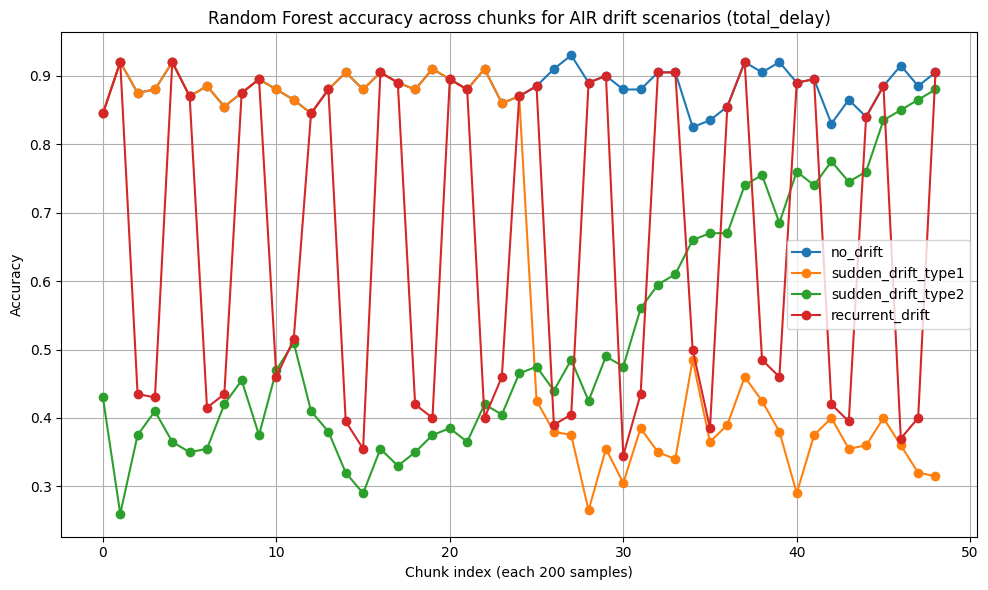

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# ===================================================
# assume these AIR drift dataframes already exist:
# df_nodrift, df_sudden_type1, df_sudden_type2, df_recurrent
# ===================================================
datasets = {
    "no_drift": df_nodrift,
    "sudden_drift_type1": df_sudden_type1,
    "sudden_drift_type2": df_sudden_type2,
    "recurrent_drift": df_recurrent,
}

chunk_size = 200
target = "total_delay"

# ===================================================
# AIR feature columns (same as your RF pipeline)
# ===================================================
feature_columns = [
    "Year",
    "Month",
    "DayOfWeek",
    "CRSElapsedTime",
    "Distance",
    "origin_lat",
    "origin_long",
    "dest_lat",
    "dest_long",
    "CRSDepTime_min",
    # "CRSArrTime_min",  # enable if you engineered it
]

# ===================================================
# helper: HHMM -> minutes since midnight
# ===================================================
def hhmm_to_minutes(x):
    x = int(x)
    hh = x // 100
    mm = x % 100
    if mm >= 60:
        mm = 59
    return hh * 60 + mm

# ===================================================
# preprocessing (applies SAME steps to base + drift sets)
# ===================================================
def prep_air(df_in):
    df_tmp = df_in.copy()
    df_tmp.columns = [c.strip() for c in df_tmp.columns]

    # drop index column
    if "Unnamed: 0" in df_tmp.columns:
        df_tmp = df_tmp.drop(columns=["Unnamed: 0"])

    # drop missing
    df_tmp = df_tmp.dropna().reset_index(drop=True)

    # engineer time features
    if "CRSDepTime" in df_tmp.columns:
        df_tmp["CRSDepTime_min"] = df_tmp["CRSDepTime"].apply(hhmm_to_minutes)

    if "CRSArrTime" in df_tmp.columns:
        df_tmp["CRSArrTime_min"] = df_tmp["CRSArrTime"].apply(hhmm_to_minutes)

    # drop original HHMM columns
    drop_time_cols = [c for c in ["CRSDepTime", "CRSArrTime"] if c in df_tmp.columns]
    if len(drop_time_cols) > 0:
        df_tmp = df_tmp.drop(columns=drop_time_cols)

    # keep only existing features
    feats = [c for c in feature_columns if c in df_tmp.columns]

    X = df_tmp[feats].copy()
    y = df_tmp[target].astype(int).values

    # force numeric if needed
    for c in feats:
        if X[c].dtype == "object":
            X[c] = pd.to_numeric(X[c], errors="coerce")

    mask = X.notna().all(axis=1)
    X = X.loc[mask].values
    y = y[mask.values]

    return X, y, feats


# ===================================================
# Train model on BASE AIR dataset (use df_nodrift)
# ===================================================
X_base, y_base, feats_used = prep_air(df_nodrift)

print("✅ Features used:", feats_used)
print("✅ Base shape:", X_base.shape, "Target shape:", y_base.shape)

scaler = StandardScaler()
X_base_scaled = scaler.fit_transform(X_base)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X_base_scaled, y_base, test_size=0.3, random_state=42, stratify=y_base
)

# model (Random Forest)
model = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
model.fit(X_train, y_train)

# optional base test
y_test_pred = model.predict(X_test)
print("✅ Base Test Accuracy:", accuracy_score(y_test, y_test_pred))


# ===================================================
# Evaluate trained model on each drift dataset (chunk-wise)
# ===================================================
plt.figure(figsize=(10, 6))

for name, df_mod in datasets.items():
    X_mod, y_mod, _ = prep_air(df_mod)

    # scale using same scaler from training
    X_mod_scaled = scaler.transform(X_mod)

    # predict (NO probabilities, direct class)
    y_pred = model.predict(X_mod_scaled)

    # chunk-wise accuracy
    n_samples = len(X_mod_scaled)
    n_chunks = n_samples // chunk_size
    accs = []

    for i in range(n_chunks):
        start, end = i * chunk_size, (i + 1) * chunk_size
        y_true_chunk = y_mod[start:end]
        y_pred_chunk = y_pred[start:end]
        if len(y_true_chunk) == 0:
            continue
        accs.append(accuracy_score(y_true_chunk, y_pred_chunk))

    plt.plot(range(len(accs)), accs, marker='o', label=name)

# ===================================================
# Plot results
# ===================================================
plt.title("Random Forest accuracy across chunks for AIR drift scenarios (total_delay)")
plt.xlabel(f"Chunk index (each {chunk_size} samples)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df_sudden_type1


,Year,Month,DayOfWeek,CRSElapsedTime,Distance,origin_lat,origin_long,dest_lat,dest_long,CRSDepTime_min,total_delay,drift_type
0,2000.000000,7.000000,1.000000,56.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,510.000000,0,sudden_type1
1,1999.000000,1.000000,6.000000,60.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,630.000000,1,sudden_type1
2,2000.000000,5.000000,1.000000,55.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,1040.000000,1,sudden_type1
3,1999.000000,4.000000,3.000000,55.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,795.000000,0,sudden_type1
4,1999.000000,10.000000,5.000000,58.000000,224.000000,47.619856,-117.533843,47.448982,-122.309313,420.000000,0,sudden_type1
...,...,...,...,...,...,...,...,...,...,...,...,...
9984,1994.403837,-6.278996,6.477337,539.142944,-2224.643283,65.943993,-165.468086,113.300063,-293.839434,3188.549937,1,sudden_type1
9985,1998.048875,-24.747719,7.643774,852.639684,759.980465,85.552614,-186.417484,51.453889,-232.400111,1362.624405,0,sudden_type1
9986,1997.975042,-8.961709,-0.060109,508.878976,-1678.386260,55.441833,61.986245,20.321699,-356.343109,1792.461409,1,sudden_type1
9987,1998.689273,-24.255989,-1.512219,259.736530,-54.134539,43.071636,-120.744841,94.517382,-224.765051,2000.260238,1,sudden_type1


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# ============================================================
# AIR DATASET – Random Forest (saves predictions CSV)
# Dataset: df_sudden_type1 (AIR)
# Target: total_delay (0/1)
# ============================================================

# === Load your dataset (AIR drift frame) ===
df = df_sudden_type1

# === Clean column names ===
df.columns = [col.strip() for col in df.columns]

# === Drop index-like column if exists ===
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# === Drop missing values ===
df = df.dropna().reset_index(drop=True)

# ============================================================
# Time Feature Engineering: CRSDepTime -> CRSDepTime_min
# ============================================================
def hhmm_to_minutes(x):
    x = int(x)
    hh = x // 100
    mm = x % 100
    if mm >= 60:
        mm = 59
    return hh * 60 + mm

if "CRSDepTime" in df.columns:
    df["CRSDepTime_min"] = df["CRSDepTime"].apply(hhmm_to_minutes)

if "CRSArrTime" in df.columns:
    df["CRSArrTime_min"] = df["CRSArrTime"].apply(hhmm_to_minutes)

drop_time_cols = [c for c in ["CRSDepTime", "CRSArrTime"] if c in df.columns]
if len(drop_time_cols) > 0:
    df = df.drop(columns=drop_time_cols)

# ============================================================
# Define feature_columns and target
# ============================================================
feature_columns = [
    "Year",
    "Month",
    "DayOfWeek",
    "CRSElapsedTime",
    "Distance",
    "origin_lat",
    "origin_long",
    "dest_lat",
    "dest_long",
    "CRSDepTime_min",
    # "CRSArrTime_min",
]
target = "total_delay"

feature_columns = [c for c in feature_columns if c in df.columns]

X = df[feature_columns].copy()
y = df[target].astype(int).values

# Force numeric safety
for c in feature_columns:
    if X[c].dtype == "object":
        X[c] = pd.to_numeric(X[c], errors="coerce")

mask = X.notna().all(axis=1)
X = X.loc[mask].reset_index(drop=True)
y = y[mask.values]

# ============================================================
# Show class counts (so you SEE the issue clearly)
# ============================================================
unique, counts = np.unique(y, return_counts=True)
print("\n✅ total_delay class distribution:", dict(zip(unique, counts)))

# If only one class exists, training a classifier is meaningless
if len(unique) < 2:
    raise ValueError(
        f"total_delay has only ONE class in this dataset after cleaning: {unique}. "
        f"Cannot train/test a classifier. Use a different drift dataframe or check labels."
    )

# ============================================================
# Split data (stratify ONLY if valid)
# ============================================================
can_stratify = np.min(counts) >= 2

if can_stratify:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
else:
    print("⚠️ Stratify disabled (a class has <2 samples). Doing normal split.")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

# ============================================================
# Scaling (optional for RF)
# ============================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ============================================================
# Train Random Forest
# ============================================================
model = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
model.fit(X_train_scaled, y_train)

# ============================================================
# Predict + Confusion Matrix + Save CSV
# ============================================================
y_pred = model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

df_results = pd.DataFrame(X_test.reset_index(drop=True), columns=feature_columns)
df_results["total_delay"] = y_test
df_results["predicted_class"] = y_pred

df_results.to_csv("air_rf_predictions.csv", index=False)
print("\nPredictions saved to: air_rf_predictions.csv")

print("\nSample predictions:")
print(df_results.head())


✅ total_delay class distribution: {np.int64(0): np.int64(4913), np.int64(1): np.int64(5076)}

Confusion Matrix:
[[ 779  695]
 [ 480 1043]]

Predictions saved to: air_rf_predictions.csv

Sample predictions:
          Year      Month  DayOfWeek  CRSElapsedTime     Distance  origin_lat  \
0  1999.000000   3.000000   2.000000      123.000000   802.000000   32.895951   
1  1999.000000   6.000000   5.000000      153.000000   925.000000   41.979595   
2  1994.362058  24.218886  -9.862275      329.191028 -5309.026062   -4.072387   
3  1999.000000   1.000000   4.000000       60.000000   227.000000   33.640444   
4  1996.870556 -21.796099  -4.688417     -135.962515 -2508.649514  103.944373   

   origin_long   dest_lat   dest_long  CRSDepTime_min  total_delay  \
0   -97.037200  41.979595  -87.904464        0.000000            1   
1   -87.904464  29.980472  -95.339722        0.000000            1   
2   -61.640712  53.375010 -322.569370    -1432.488261            1   
3   -84.426944  35.214011 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# ============================================================
# AIR DATASET – Random Forest Classification
# Uses df_sudden_type1 (AIR drift dataset)
# Target: total_delay (binary)
# ============================================================

# === Load dataset ===
df = df_sudden_type1.copy()

# === Clean column names ===
df.columns = [col.strip() for col in df.columns]

# === Drop missing values ===
df = df.dropna().reset_index(drop=True)

# ============================================================
# AIR FEATURES + TARGET
# ============================================================
feature_columns = [
    "Year",
    "Month",
    "DayOfWeek",
    "CRSElapsedTime",
    "Distance",
    "origin_lat",
    "origin_long",
    "dest_lat",
    "dest_long",
    "CRSDepTime_min"
]
target_col = "total_delay"

# Keep only columns that exist (safety)
feature_columns = [c for c in feature_columns if c in df.columns]

if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Available columns: {list(df.columns)}")

# === Select Features and Target ===
X = df[feature_columns].copy()
y = df[target_col].astype(int).copy()

# Force numeric conversion if any column is object
for c in feature_columns:
    if X[c].dtype == "object":
        X[c] = pd.to_numeric(X[c], errors="coerce")

# Drop any NaNs created by coercion (align X and y)
mask = X.notna().all(axis=1)
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

# ============================================================
# Robust stratify (prevents "least populated class has only 1")
# ============================================================
counts = y.value_counts()
print("\n✅ total_delay class distribution:")
print(counts)

can_stratify = (counts.shape[0] >= 2) and (counts.min() >= 2)

# === Split data ===
if can_stratify:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    print("✅ Using stratified split.")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, shuffle=True
    )
    print("⚠️ Stratify disabled (a class has <2 samples). Using normal split.")

# ============================================================
# Scaling (not needed for RF, kept only for pipeline consistency)
# ============================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ============================================================
# Random Forest
# ============================================================
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf.fit(X_train_scaled, y_train)

# === Predict ===
y_pred = rf.predict(X_test_scaled)

# === Evaluation ===
print("\n✅ Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("✅ Accuracy:", accuracy_score(y_test, y_pred))

# ============================================================
# Save predictions like your reference script
# (Use original unscaled feature values for readability)
# ============================================================
df_results = X_test.copy()
df_results["true_class"] = y_test.values
df_results["predicted_class"] = y_pred

df_results.to_csv("air_rf_predictions.csv", index=False)
print("\n✅ Predictions saved to: air_rf_predictions.csv")

print("\n✅ Sample predictions:")
print(df_results.head())



✅ total_delay class distribution:
total_delay
1    5076
0    4913
Name: count, dtype: int64
✅ Using stratified split.

✅ Confusion Matrix:
[[ 779  695]
 [ 480 1043]]

✅ Classification Report:
              precision    recall  f1-score   support

           0     0.6187    0.5285    0.5701      1474
           1     0.6001    0.6848    0.6397      1523

    accuracy                         0.6079      2997
   macro avg     0.6094    0.6067    0.6049      2997
weighted avg     0.6093    0.6079    0.6054      2997

✅ Accuracy: 0.6079412746079412

✅ Predictions saved to: air_rf_predictions.csv

✅ Sample predictions:
             Year      Month  DayOfWeek  CRSElapsedTime     Distance  \
2063  1999.000000   3.000000   2.000000      123.000000   802.000000   
3601  1999.000000   6.000000   5.000000      153.000000   925.000000   
8797  1994.362058  24.218886  -9.862275      329.191028 -5309.026062   
2896  1999.000000   1.000000   4.000000       60.000000   227.000000   
7000  1996.870556 

In [ ]:
df_results

,Year,Month,DayOfWeek,CRSElapsedTime,Distance,origin_lat,origin_long,dest_lat,dest_long,CRSDepTime_min,true_class,predicted_class
2063,1999.000000,3.000000,2.000000,123.000000,802.000000,32.895951,-97.037200,41.979595,-87.904464,0.000000,1,0
3601,1999.000000,6.000000,5.000000,153.000000,925.000000,41.979595,-87.904464,29.980472,-95.339722,0.000000,1,0
8797,1994.362058,24.218886,-9.862275,329.191028,-5309.026062,-4.072387,-61.640712,53.375010,-322.569370,-1432.488261,1,1
2896,1999.000000,1.000000,4.000000,60.000000,227.000000,33.640444,-84.426944,35.214011,-80.943126,810.000000,0,0
7000,1996.870556,-21.796099,-4.688417,-135.962515,-2508.649514,103.944373,140.299182,90.528540,-234.336655,1435.595366,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2793,2000.000000,7.000000,1.000000,219.000000,1501.000000,44.880547,-93.216922,25.793250,-80.290556,785.000000,1,0
5440,1996.527231,-34.615309,28.635888,178.880162,-1107.012746,64.374973,-159.407532,76.924605,-170.229375,3219.371927,1,1
5509,1999.162816,-18.929115,28.583728,581.710130,-139.684304,53.292533,17.198993,67.135360,-210.063653,212.823077,1,0
5478,1998.016122,-6.351981,13.371302,1009.700524,6373.366511,83.408644,17.445710,35.545830,-146.370685,1790.398415,1,1


Surrogate fidelity (vs RF predicted_class): 0.8889


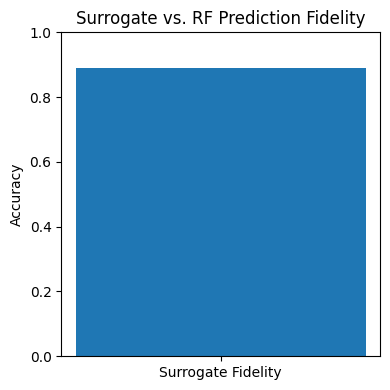

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# =======================================================
# AIR DATASET — SURROGATE MODEL (Decision Tree)
# Fits a simple interpretable model to mimic the RF predictions
# Requires:
#   - df_results (created from AIR RF pipeline)
#   - features (AIR feature list used to train RF)
# df_results must contain:
#   - all feature columns in `features`
#   - "predicted_class" (0/1 from RF)
# =======================================================

# ---- AIR feature list (use the same as your RF pipeline) ----
features = [
    "Year",
    "Month",
    "DayOfWeek",
    "CRSElapsedTime",
    "Distance",
    "origin_lat",
    "origin_long",
    "dest_lat",
    "dest_long",
    "CRSDepTime_min"
]

# Safety: keep only existing columns
features = [c for c in features if c in df_results.columns]

# =======================================================
# Build surrogate training data
# =======================================================
X_surrogate = df_results[features].copy()

# Ensure numeric
for c in features:
    if X_surrogate[c].dtype == "object":
        X_surrogate[c] = pd.to_numeric(X_surrogate[c], errors="coerce")

# Drop rows with NaNs (align with predicted_class)
mask = X_surrogate.notna().all(axis=1) & df_results["predicted_class"].notna()
X_surrogate = X_surrogate.loc[mask].values

# Predicted labels from black-box (RF) — typically already 0/1 ints
y_bb = df_results.loc[mask, "predicted_class"].astype(int).values

# If predicted_class is not numeric (just in case), encode it
if not np.issubdtype(y_bb.dtype, np.integer):
    y_bb = LabelEncoder().fit_transform(df_results.loc[mask, "predicted_class"].astype(str).values)

# =======================================================
# Train surrogate (interpretable)
# =======================================================
surrogate_model = DecisionTreeClassifier(max_depth=4, random_state=42)
surrogate_model.fit(X_surrogate, y_bb)

# =======================================================
# Fidelity: surrogate vs black-box predictions
# =======================================================
y_surrogate_pred = surrogate_model.predict(X_surrogate)
acc = accuracy_score(y_bb, y_surrogate_pred)
print(f"Surrogate fidelity (vs RF predicted_class): {acc:.4f}")

# =======================================================
# Plot: surrogate fidelity bar
# =======================================================
plt.figure(figsize=(4, 4))
plt.bar(['Surrogate Fidelity'], [acc])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Surrogate vs. RF Prediction Fidelity')
plt.tight_layout()
plt.show()


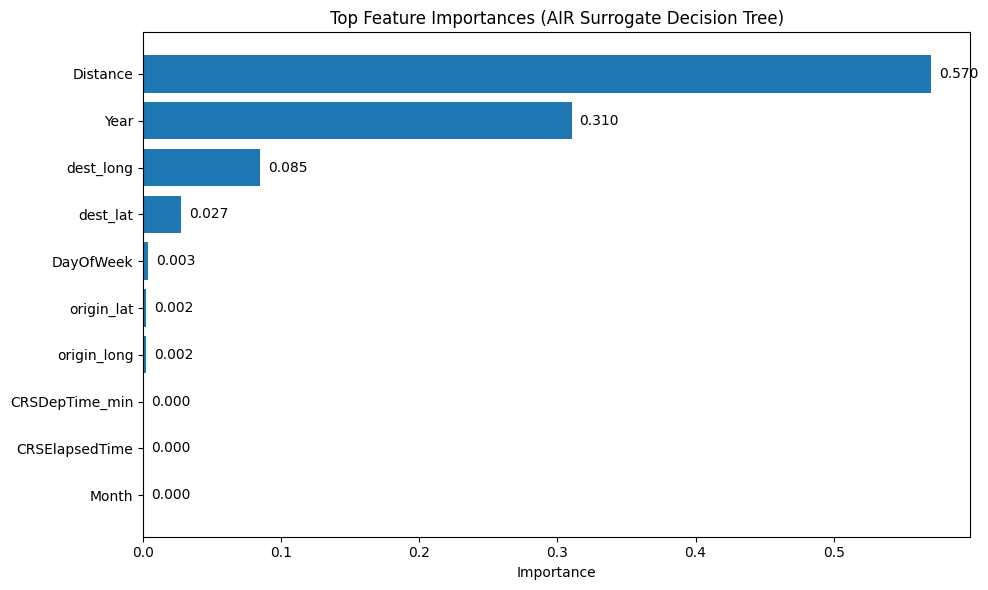

In [ ]:
# =======================================================
# PLOT 2 (AIR): Top Feature Importances from surrogate tree
# Assumes:
#   - surrogate_model is already trained (DecisionTreeClassifier)
#   - features is the AIR feature list used to train the surrogate
# =======================================================

import numpy as np
import matplotlib.pyplot as plt

# If you didn't define features above, define AIR features here:
features = [
    "Year",
    "Month",
    "DayOfWeek",
    "CRSElapsedTime",
    "Distance",
    "origin_lat",
    "origin_long",
    "dest_lat",
    "dest_long",
    "CRSDepTime_min"
]

# Keep only features actually used in training (safety)
# (If you trained surrogate_model using filtered features, reuse that same list)
try:
    used_features = features
    # If df_results exists, filter to existing columns
    used_features = [c for c in used_features if c in df_results.columns]
except NameError:
    used_features = features

importances = surrogate_model.feature_importances_
n_used = len(used_features)

# Align lengths just in case (prevents mismatch errors)
importances = importances[:n_used]

indices = np.argsort(importances)[::-1]  # descending
top_n = min(10, n_used)

top_indices = indices[:top_n]
top_features = [used_features[i] for i in top_indices]
top_importances = importances[top_indices]

plt.figure(figsize=(10, 6))
bars = plt.barh(range(top_n), top_importances[::-1])
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel("Importance")
plt.title("Top Feature Importances (AIR Surrogate Decision Tree)")

# Add numerical values to bars
for i, b in enumerate(bars):
    width = b.get_width()
    plt.text(
        width + (0.01 * (top_importances.max() if top_importances.max() > 0 else 1.0)),
        b.get_y() + b.get_height() / 2,
        f"{top_importances[::-1][i]:.3f}",
        va="center"
    )

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
# === Get feature importances from the trained surrogate model ===
importances = surrogate_model.feature_importances_
# === Build DataFrame of all features with their importances ===
df_baseline_importance = pd.DataFrame({
    'feature': features,
    'importance': importances
})
# === Sort in descending order ===
df_baseline_importance = df_baseline_importance.sort_values(
    by='importance', ascending=False
).reset_index(drop=True)
# === Select top 10 features ===
df_baseline_top10 = df_baseline_importance.head(10)
# === Display top 10 ===
print(df_baseline_top10)

          feature  importance
0        Distance    0.570296
1            Year    0.310198
2       dest_long    0.084705
3        dest_lat    0.027292
4       DayOfWeek    0.003389
5      origin_lat    0.002085
6     origin_long    0.002035
7           Month    0.000000
8  CRSElapsedTime    0.000000
9  CRSDepTime_min    0.000000


**Base Statistics**
---

In [ ]:
import pandas as pd
import numpy as np

# =======================================================
# AIR DATASET: Block-wise baseline statistics (mean/var/std)
# =======================================================

# --- Configuration ---
block_size = 10  # Number of samples per block

selected_cols = [
    "Year",
    "Month",
    "DayOfWeek",
    "CRSElapsedTime",
    "Distance",
    "origin_lat",
    "origin_long",
    "dest_lat",
    "dest_long",
    "CRSDepTime_min"
]

# Make a copy of the AIR dataset (df should be your AIR dataframe)
df_tmp = df.copy().reset_index(drop=True)
df_tmp.columns = [c.strip() for c in df_tmp.columns]

# Assign block index
df_tmp["block"] = df_tmp.index // block_size

# Keep only columns that exist
cols_to_use = [c for c in selected_cols if c in df_tmp.columns]
if len(cols_to_use) < len(selected_cols):
    missing = sorted(set(selected_cols) - set(cols_to_use))
    print("Warning: some selected AIR columns missing and skipped:", missing)

# Force numeric (important if any coords/times loaded as object)
for c in cols_to_use:
    if df_tmp[c].dtype == "object":
        df_tmp[c] = pd.to_numeric(df_tmp[c], errors="coerce")

# Drop rows that became NaN after coercion (so stats are valid)
df_tmp = df_tmp.dropna(subset=cols_to_use).reset_index(drop=True)
df_tmp["block"] = df_tmp.index // block_size  # reassign blocks after dropping

# Compute mean, variance, and standard deviation per block
df_baseline_stats = (
    df_tmp
    .groupby("block")[cols_to_use]
    .agg(["mean", "var", "std"])
)

# Flatten MultiIndex columns: e.g., Distance_mean, Distance_var, Distance_std
df_baseline_stats.columns = [f"{col}_{stat}" for col, stat in df_baseline_stats.columns]

# Reset index so 'block' becomes a column
df_baseline_stats = df_baseline_stats.reset_index()

# Save to CSV
df_baseline_stats.to_csv("air_baseline_stats.csv", index=False)

# Display
df_baseline_stats


,block,Year_mean,Year_var,Year_std,Month_mean,Month_var,Month_std,DayOfWeek_mean,DayOfWeek_var,DayOfWeek_std,...,origin_long_std,dest_lat_mean,dest_lat_var,dest_lat_std,dest_long_mean,dest_long_var,dest_long_std,CRSDepTime_min_mean,CRSDepTime_min_var,CRSDepTime_min_std
0,0,1999.500000,0.277778,0.527046,6.400000,10.044444,3.169297,2.900000,4.100000,2.024846,...,9.369632,47.448982,0.000000,0.000000,-122.309313,0.000000,0.000000,757.000000,6.591778e+04,256.744577
1,1,1999.500000,0.277778,0.527046,6.200000,10.400000,3.224903,4.900000,3.211111,1.791957,...,3.591571,47.448982,0.000000,0.000000,-122.309313,0.000000,0.000000,854.800000,2.343337e+05,484.080296
2,2,1999.600000,0.266667,0.516398,5.700000,9.344444,3.056868,4.900000,4.100000,2.024846,...,9.749856,47.448982,0.000000,0.000000,-122.309313,0.000000,0.000000,970.400000,8.801271e+04,296.669363
3,3,1999.400000,0.266667,0.516398,6.300000,11.344444,3.368151,2.700000,4.011111,2.002776,...,4.306036,47.448982,0.000000,0.000000,-122.309313,0.000000,0.000000,776.400000,4.122360e+04,203.035957
4,4,1999.600000,0.266667,0.516398,8.200000,16.400000,4.049691,3.200000,5.511111,2.347576,...,0.122995,47.448982,0.000000,0.000000,-122.309313,0.000000,0.000000,855.300000,5.130401e+04,226.503888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,994,1998.178733,5.339873,2.310817,-10.570463,201.974433,14.211771,17.922469,142.193643,11.924498,...,41.749292,72.694416,436.484654,20.892215,-177.224955,11799.184707,108.624052,2301.944969,9.078947e+05,952.835107
995,995,1997.412492,11.535431,3.396385,-13.442025,322.368030,17.954610,12.427975,95.536098,9.774257,...,67.306109,73.271693,955.169854,30.905822,-183.326421,6222.285116,78.881462,1310.044860,2.262368e+06,1504.117061
996,996,1997.223914,1.999454,1.414021,-3.944125,837.109013,28.932836,1.323078,60.489834,7.777521,...,75.526682,69.156937,789.760666,28.102681,-108.738517,18055.158944,134.369487,1779.963910,4.188521e+06,2046.587598
997,997,1996.579460,6.667048,2.582063,-1.436142,88.749487,9.420695,11.421781,69.413241,8.331461,...,103.155327,83.323253,903.137875,30.052252,-160.282674,6286.722011,79.288852,2601.907921,1.278522e+06,1130.717304


**New Data Statictsics**
---

In [ ]:
import pandas as pd
import numpy as np

# =======================================================
# AIR DATASET: Combine drift datasets + block-wise stats
# =======================================================

# --- Configuration ---
block_size = 10  # samples per block
selected_cols = [
    "Year",
    "Month",
    "DayOfWeek",
    "CRSElapsedTime",
    "Distance",
    "origin_lat",
    "origin_long",
    "dest_lat",
    "dest_long",
    "CRSDepTime_min"
]

# --- Combine all AIR drift datasets into one ---
df_all = pd.concat(
    [df_sudden_type1, df_sudden_type2, df_recurrent],
    axis=0,
    ignore_index=True
)

# Clean column names
df_all.columns = [c.strip() for c in df_all.columns]

# --- Assign block IDs ---
df_all = df_all.reset_index(drop=True)
df_all["block"] = df_all.index // block_size

# --- Filter only available columns ---
cols_to_use = [c for c in selected_cols if c in df_all.columns]
if len(cols_to_use) < len(selected_cols):
    missing = sorted(set(selected_cols) - set(cols_to_use))
    print("⚠️ Warning: some selected AIR columns missing and skipped:", missing)

# --- Force numeric (important for coords/times if loaded as object) ---
for c in cols_to_use:
    if df_all[c].dtype == "object":
        df_all[c] = pd.to_numeric(df_all[c], errors="coerce")

# Drop rows that became NaN after coercion (so stats are valid)
df_all = df_all.dropna(subset=cols_to_use).reset_index(drop=True)
df_all["block"] = df_all.index // block_size  # reassign blocks after dropping

# --- Compute mean/variance/std for each block ---
df_all_stats = (
    df_all
    .groupby("block")[cols_to_use]
    .agg(["mean", "var", "std"])
)

# --- Flatten multi-level column names ---
df_all_stats.columns = [f"{col}_{stat}" for col, stat in df_all_stats.columns]

# --- Reset index so 'block' becomes a column ---
df_all_stats = df_all_stats.reset_index()

# --- Save results ---
df_all_stats.to_csv("air_all_drift_stats.csv", index=False)
print("✅ Combined drift statistics saved to air_all_drift_stats.csv")

# --- Preview ---
df_all_stats.head()



✅ Combined drift statistics saved to air_all_drift_stats.csv


,block,Year_mean,Year_var,Year_std,Month_mean,Month_var,Month_std,DayOfWeek_mean,DayOfWeek_var,DayOfWeek_std,...,origin_long_std,dest_lat_mean,dest_lat_var,dest_lat_std,dest_long_mean,dest_long_var,dest_long_std,CRSDepTime_min_mean,CRSDepTime_min_var,CRSDepTime_min_std
0,0,1999.5,0.277778,0.527046,6.4,10.044444,3.169297,2.9,4.100000,2.024846,...,9.369632,47.448982,0.0,0.0,-122.309313,0.0,0.0,757.0,65917.777778,256.744577
1,1,1999.5,0.277778,0.527046,6.2,10.400000,3.224903,4.9,3.211111,1.791957,...,3.591571,47.448982,0.0,0.0,-122.309313,0.0,0.0,854.8,234333.733333,484.080296
2,2,1999.6,0.266667,0.516398,5.7,9.344444,3.056868,4.9,4.100000,2.024846,...,9.749856,47.448982,0.0,0.0,-122.309313,0.0,0.0,970.4,88012.711111,296.669363
3,3,1999.4,0.266667,0.516398,6.3,11.344444,3.368151,2.7,4.011111,2.002776,...,4.306036,47.448982,0.0,0.0,-122.309313,0.0,0.0,776.4,41223.600000,203.035957
4,4,1999.6,0.266667,0.516398,8.2,16.400000,4.049691,3.2,5.511111,2.347576,...,0.122995,47.448982,0.0,0.0,-122.309313,0.0,0.0,855.3,51304.011111,226.503888


In [ ]:
import pandas as pd
import numpy as np

# ============================================================
# Load pre-computed statistics for weather dataset
# ============================================================
df_baseline = pd.read_csv("air_baseline_stats.csv")
df_drifted  = pd.read_csv("air_all_drift_stats.csv")

# ============================================================
# Baseline reference vector: mean across all baseline blocks
# ============================================================
baseline_row = df_baseline.mean()

# ============================================================
# Collect all columns except 'block'
# ============================================================
cols = [c for c in df_baseline.columns if c != 'block']
base_features = sorted(set(col.rsplit('_', 1)[0] for col in cols))

records = []

# ============================================================
# Compute FDDS block-wise (correct formula)
# FDDS_j = (μb-μw)^2 + (vb+vw-2√(vb·vw))
# ============================================================
for idx, drift_row in df_drifted.iterrows():
    block_id = drift_row.get("block", idx)
    row_result = {"block": block_id}

    for base in base_features:
        mean_b = baseline_row.get(f"{base}_mean", np.nan)
        var_b  = baseline_row.get(f"{base}_var", np.nan)

        if pd.isna(var_b):
            std_b = baseline_row.get(f"{base}_std", np.nan)
            var_b = std_b**2 if not pd.isna(std_b) else np.nan

        mean_w = drift_row.get(f"{base}_mean", np.nan)
        var_w  = drift_row.get(f"{base}_var", np.nan)

        if pd.isna(var_w):
            std_w = drift_row.get(f"{base}_std", np.nan)
            var_w = std_w**2 if not pd.isna(std_w) else np.nan

        if pd.isna(mean_b) or pd.isna(mean_w) or pd.isna(var_b) or pd.isna(var_w):
            row_result[base] = np.nan
        else:
            d = (mean_b - mean_w)**2 + (var_b + var_w - 2*np.sqrt(var_b * var_w))
            row_result[base] = d

    records.append(row_result)

df_fdds_vector = pd.DataFrame(records)

df_fdds_vector.to_csv("weather_fdds_vector.csv", index=False)

print("✅ Weather FDDS vector saved.")
df_fdds_vector.head()


✅ Weather FDDS vector saved.


,block,CRSDepTime_min,CRSElapsedTime,DayOfWeek,Distance,Month,Year,dest_lat,dest_long,origin_lat,origin_long
0,0.0,1.073121e+06,84701.752698,51.861532,3.490963e+06,138.378301,2.748097,434.148736,4775.781489,363.199735,5840.599888
1,1.0,6.350919e+05,66841.625222,38.543378,9.132413e+06,134.663236,2.748097,434.148736,4775.781489,329.256573,4384.404774
2,2.0,7.911187e+05,58326.442952,36.053718,6.357929e+06,131.661306,2.990435,434.148736,4775.781489,537.845335,4928.930730
3,3.0,1.142034e+06,83329.684407,54.113595,5.307976e+06,133.243096,2.581577,434.148736,4775.781489,498.010361,7051.986693
4,4.0,1.013147e+06,94708.955529,45.709575,5.873418e+06,149.531108,2.990435,434.148736,4775.781489,550.510422,7777.343046


In [ ]:
df_baseline_top10

,feature,importance
0,Distance,0.570296
1,Year,0.310198
2,dest_long,0.084705
3,dest_lat,0.027292
4,DayOfWeek,0.003389
5,origin_lat,0.002085
6,origin_long,0.002035
7,Month,0.000000
8,CRSElapsedTime,0.000000
9,CRSDepTime_min,0.000000


In [ ]:
import pandas as pd

# ============================================================
# Load supporting data (already created previously)
# ============================================================
# df_fdds_vector     → per-feature FDDS values from Cell 1 (e.g., weather_fdds_vector)
# df_baseline_top10  → Top 10 surrogate feature importances (already loaded earlier)

# If needed to reload from files (optional):
# df_fdds_vector    = pd.read_csv("weather_fdds_vector.csv")
# df_baseline_top10 = pd.read_csv("weather_baseline_top10.csv")

# ============================================================
# Convert top-10 importance DataFrame into dictionary
# ============================================================
importance_dict = dict(zip(df_baseline_top10["feature"], df_baseline_top10["importance"]))

# Make a working copy of the FDDS vector
df_drift_exposure = df_fdds_vector.copy()

# ============================================================
# Compute MLS Drift Exposure Score (weighted FDDS) per block
# Same structure as your electricity code
# ============================================================
des_values = []

for idx, row in df_drift_exposure.iterrows():
    des_total = 0.0
    for feature_name, importance in importance_dict.items():
        # Match all feature columns corresponding to this base feature
        matching_cols = [c for c in df_drift_exposure.columns if c.startswith(feature_name)]
        for col in matching_cols:
            des_total += importance * row[col]
    des_values.append(des_total)

# Store the final weighted score (keep your naming exactly)
df_drift_exposure["FDDS"] = des_values

# ============================================================
# Save the results
# ============================================================
df_drift_exposure.to_csv("weather_drift_exposure_scores.csv", index=False)

print("✅ MLS Drift Exposure Scores computed and saved to weather_drift_exposure_scores.csv")
print(df_drift_exposure[["block", "FDDS"]].head())


✅ MLS Drift Exposure Scores computed and saved to weather_drift_exposure_scores.csv
   block          FDDS
0    0.0  1.991314e+06
1    1.0  5.208609e+06
2    2.0  3.626333e+06
3    3.0  3.027552e+06
4    4.0  3.350024e+06


In [ ]:
df_baseline_top10

,feature,importance
0,Distance,0.570296
1,Year,0.310198
2,dest_long,0.084705
3,dest_lat,0.027292
4,DayOfWeek,0.003389
5,origin_lat,0.002085
6,origin_long,0.002035
7,Month,0.000000
8,CRSElapsedTime,0.000000
9,CRSDepTime_min,0.000000


In [ ]:
df_drift_exposure

,block,CRSDepTime_min,CRSElapsedTime,DayOfWeek,Distance,Month,Year,dest_lat,dest_long,origin_lat,origin_long,FDDS
0,0.0,1.073121e+06,84701.752698,51.861532,3.490963e+06,138.378301,2.748097,434.148736,4775.781489,363.199735,5840.599888,1.991314e+06
1,1.0,6.350919e+05,66841.625222,38.543378,9.132413e+06,134.663236,2.748097,434.148736,4775.781489,329.256573,4384.404774,5.208609e+06
2,2.0,7.911187e+05,58326.442952,36.053718,6.357929e+06,131.661306,2.990435,434.148736,4775.781489,537.845335,4928.930730,3.626333e+06
3,3.0,1.142034e+06,83329.684407,54.113595,5.307976e+06,133.243096,2.581577,434.148736,4775.781489,498.010361,7051.986693,3.027552e+06
4,4.0,1.013147e+06,94708.955529,45.709575,5.873418e+06,149.531108,2.990435,434.148736,4775.781489,550.510422,7777.343046,3.350024e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
2992,2992.0,7.083957e+05,104595.256734,60.472034,4.547050e+06,140.457226,2.581577,308.344220,3751.273256,321.962955,5185.684452,2.593505e+06
2993,2993.0,7.909343e+05,118865.217887,42.429177,4.618532e+06,148.379667,2.990435,287.479972,5121.680170,350.370650,3280.025858,2.634382e+06
2994,2994.0,8.777309e+05,121064.330810,46.140712,4.670208e+06,137.824944,4.320541,75.311094,1583.575178,63.458137,3125.522743,2.663547e+06
2995,2995.0,6.987150e+05,110486.010713,39.052007,4.435171e+06,167.892968,2.496027,499.626605,3260.900939,419.893054,9392.835975,2.529673e+06


In [ ]:
df_drift_exposure.to_csv("df_fdds_air.csv")

<Axes: >

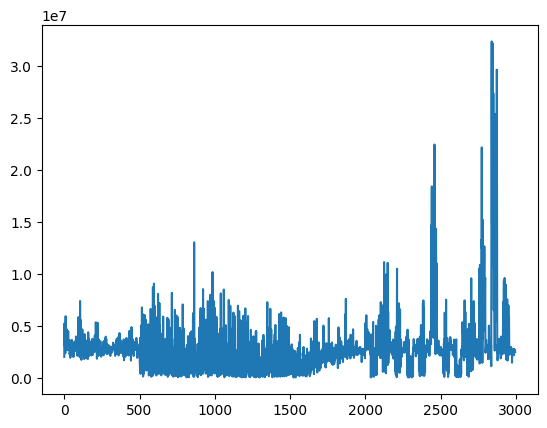

In [ ]:
df_drift_exposure["FDDS"].plot()

In [ ]:
import pandas as pd
import numpy as np

# ============================================================
# Load MLS Drift Exposure Scores (if not already in memory)
# ============================================================
# df_drift_exposure = pd.read_csv("electricity_drift_exposure_scores.csv")
# ============================================================
# Configuration
# ============================================================
block_group_size = 5    # Number of blocks per group
threshold_scaled = 0.70 # Scaled drift threshold (0–1 range)

# ============================================================
# Step 1: Assign group IDs (every 5 blocks form a group)
# ============================================================
df_drift_exposure["block_group"] = (df_drift_exposure["block"] // block_group_size).astype(int)

# ============================================================
# Step 2: Aggregate by group — compute average DES per block group
# ============================================================
group_results = []
for group_id, subset in df_drift_exposure.groupby("block_group"):
    avg_des = subset["FDDS"].mean()
    group_results.append({
        "block_range": f"{subset['block'].min():.0f}-{subset['block'].max():.0f}",
        "total_blocks": len(subset),
        "avg_FDDS": avg_des
    })

df_summary = pd.DataFrame(group_results)

# ============================================================
# Step 3: Scale avg_DES into [0, 1] range for comparison
# ============================================================
min_val = df_summary["avg_FDDS"].min()
max_val = df_summary["avg_FDDS"].max()
df_summary["avg_FDDS_scaled"] = (df_summary["avg_FDDS"] - min_val) / (max_val - min_val)

# ============================================================
# Step 4: Determine drift type based on scaled DES threshold
# ============================================================
df_summary["final_drift"] = np.where(
    df_summary["avg_FDDS_scaled"] > threshold_scaled,
    "REAL_DRIFT",
    "PSEUDO_DRIFT"
)

# ============================================================
# Save and display
# ============================================================
df_summary.to_csv("electricity_drift_summary.csv", index=False)

print("✅ Drift summary saved to electricity_drift_summary.csv")
print(df_summary)


✅ Drift summary saved to electricity_drift_summary.csv
    block_range  total_blocks      avg_FDDS  avg_FDDS_scaled   final_drift
0           0-4             5  3.440766e+06         0.137436  PSEUDO_DRIFT
1           5-9             5  3.532356e+06         0.141344  PSEUDO_DRIFT
2         10-14             5  2.920697e+06         0.115244  PSEUDO_DRIFT
3         15-19             5  3.488133e+06         0.139457  PSEUDO_DRIFT
4         20-24             5  3.038350e+06         0.120265  PSEUDO_DRIFT
..          ...           ...           ...              ...           ...
595   2975-2979             5  2.296078e+06         0.088591  PSEUDO_DRIFT
596   2980-2984             5  2.530940e+06         0.098613  PSEUDO_DRIFT
597   2985-2989             5  2.583650e+06         0.100862  PSEUDO_DRIFT
598   2990-2994             5  2.649943e+06         0.103691  PSEUDO_DRIFT
599   2995-2996             2  2.491175e+06         0.096916  PSEUDO_DRIFT

[600 rows x 5 columns]


In [ ]:
df_summary.to_csv("MDDP_5_air.csv", index=False)

<Axes: >

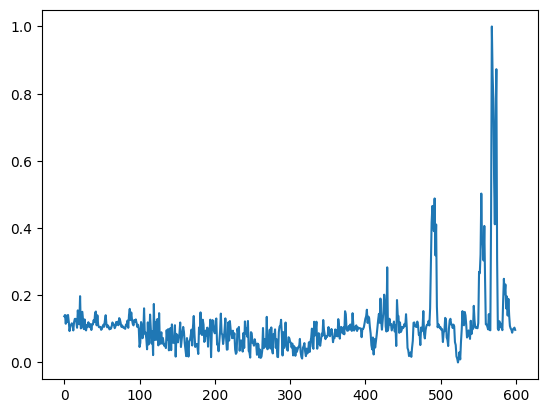

In [ ]:
df_summary['avg_FDDS_scaled'].plot()

In [ ]:
df_summary['final_drift'].value_counts()

,count
final_drift,
PSEUDO_DRIFT,595
REAL_DRIFT,5


In [ ]:
df_all

,Year,Month,DayOfWeek,CRSElapsedTime,Distance,origin_lat,origin_long,dest_lat,dest_long,CRSDepTime_min,total_delay,drift_type,block
0,2000.0,7.0,1.0,56.0,224.0,47.619856,-117.533843,47.448982,-122.309313,510.0,0,sudden_type1,0
1,1999.0,1.0,6.0,60.0,224.0,47.619856,-117.533843,47.448982,-122.309313,630.0,1,sudden_type1,0
2,2000.0,5.0,1.0,55.0,224.0,47.619856,-117.533843,47.448982,-122.309313,1040.0,1,sudden_type1,0
3,1999.0,4.0,3.0,55.0,224.0,47.619856,-117.533843,47.448982,-122.309313,795.0,0,sudden_type1,0
4,1999.0,10.0,5.0,58.0,224.0,47.619856,-117.533843,47.448982,-122.309313,420.0,0,sudden_type1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29962,2000.0,10.0,7.0,44.0,183.0,64.512202,-165.445246,66.884677,-162.598550,506.0,0,recurrent,2996
29963,1999.0,2.0,1.0,37.0,95.0,58.354962,-134.576276,57.047138,-135.361598,610.0,1,recurrent,2996
29964,1999.0,7.0,5.0,28.0,45.0,18.337306,-64.973361,17.701889,-64.798556,880.0,0,recurrent,2996
29965,2000.0,1.0,5.0,36.0,82.0,55.355569,-131.713740,56.484326,-132.369824,617.0,0,recurrent,2996


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# ============================================================
# AIR Configuration (same features + target as your RF pipeline)
# ============================================================
features = [
    "Year",
    "Month",
    "DayOfWeek",
    "CRSElapsedTime",
    "Distance",
    "origin_lat",
    "origin_long",
    "dest_lat",
    "dest_long",
    "CRSDepTime_min"
]
target = "total_delay"
block_window = 5  # evaluate every 5 consecutive blocks

# ============================================================
# Input DataFrame (combined AIR drift dataset)
# Requires:
#   - df_all (combined drift dataset with 'block' column already assigned)
#   - scaler (fitted StandardScaler from RF pipeline; optional but used for consistency)
#   - rf (trained RandomForestClassifier)
# ============================================================

df_tmp = df_all.copy()
df_tmp.columns = [c.strip() for c in df_tmp.columns]

# Ensure block exists
if "block" not in df_tmp.columns:
    raise ValueError("df_all must contain a 'block' column. Please assign blocks before running this.")

# Keep only columns that exist (safety)
features = [c for c in features if c in df_tmp.columns]
if target not in df_tmp.columns:
    raise ValueError(f"Target column '{target}' not found in df_all. Available columns: {list(df_tmp.columns)}")

# Sort by block
df_tmp = df_tmp.sort_values(by="block").reset_index(drop=True)

# Ensure numeric target (binary)
df_tmp[target] = pd.to_numeric(df_tmp[target], errors="coerce").astype("Int64")
df_tmp = df_tmp.dropna(subset=[target]).reset_index(drop=True)
df_tmp[target] = df_tmp[target].astype(int)

# ============================================================
# Evaluate model performance per 5-block chunk
# (Ground-truth accuracy per window of blocks)
# ============================================================
accuracies = []
block_ids = sorted(df_tmp["block"].unique())

for i in range(0, len(block_ids), block_window):
    block_chunk = block_ids[i:i + block_window]
    df_chunk = df_tmp[df_tmp["block"].isin(block_chunk)]
    if df_chunk.empty:
        continue

    # Prepare feature and label arrays
    X_chunk = df_chunk[features].copy()

    # Force numeric conversion for safety
    for c in features:
        if X_chunk[c].dtype == "object":
            X_chunk[c] = pd.to_numeric(X_chunk[c], errors="coerce")

    # Drop rows with NaNs in features
    mask = X_chunk.notna().all(axis=1)
    X_chunk = X_chunk.loc[mask]
    y_chunk = df_chunk.loc[mask, target].values

    if len(X_chunk) == 0:
        continue

    # Scale using the same fitted scaler used during training (kept for pipeline consistency)
    X_chunk_scaled = scaler.transform(X_chunk)

    # Predict with Random Forest
    y_pred = rf.predict(X_chunk_scaled)

    # Compute accuracy
    accuracy = accuracy_score(y_chunk, y_pred)

    accuracies.append({
        "block_range": f"{block_chunk[0]}-{block_chunk[-1]}",
        "total_blocks": len(block_chunk),
        "n_samples": int(len(y_chunk)),
        "accuracy": float(accuracy)
    })

# ============================================================
# Build summary DataFrame
# ============================================================
df_accuracies = pd.DataFrame(accuracies)

# Save for later drift comparison (ground truth)
df_accuracies.to_csv("air_blockwise_accuracies.csv", index=False)

print("✅ Block-wise accuracy ground truth saved to air_blockwise_accuracies.csv")
print(df_accuracies.head())


✅ Block-wise accuracy ground truth saved to air_blockwise_accuracies.csv
  block_range  total_blocks  n_samples  accuracy
0         0-4             5         50      0.86
1         5-9             5         50      0.92
2       10-14             5         50      0.90
3       15-19             5         50      0.88
4       20-24             5         50      0.96


In [ ]:
df_accuracies

,block_range,total_blocks,n_samples,accuracy
0,0-4,5,50,0.860000
1,5-9,5,50,0.920000
2,10-14,5,50,0.900000
3,15-19,5,50,0.880000
4,20-24,5,50,0.960000
...,...,...,...,...
595,2975-2979,5,50,0.520000
596,2980-2984,5,50,0.700000
597,2985-2989,5,50,0.500000
598,2990-2994,5,50,0.520000


In [ ]:
df_accuracies.to_csv("Ground_5_air.csv")

In [ ]:
import numpy as np
# Assume df is your dataframe with 'accuracy'
df_accuracies["Ground truth"] = np.where(df_accuracies["accuracy"] > 0.50, "PSEUDO_DRIFT", "REAL_DRIFT")
df_accuracies

,block_range,total_blocks,n_samples,accuracy,Ground truth
0,0-4,5,50,0.860000,PSEUDO_DRIFT
1,5-9,5,50,0.920000,PSEUDO_DRIFT
2,10-14,5,50,0.900000,PSEUDO_DRIFT
3,15-19,5,50,0.880000,PSEUDO_DRIFT
4,20-24,5,50,0.960000,PSEUDO_DRIFT
...,...,...,...,...,...
595,2975-2979,5,50,0.520000,PSEUDO_DRIFT
596,2980-2984,5,50,0.700000,PSEUDO_DRIFT
597,2985-2989,5,50,0.500000,REAL_DRIFT
598,2990-2994,5,50,0.520000,PSEUDO_DRIFT


<Axes: >

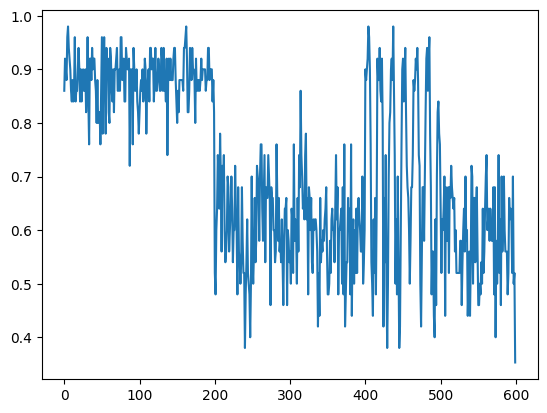

In [ ]:
df_accuracies["accuracy"].plot()

In [ ]:
df_accuracies['Ground truth'].value_counts()

,count
Ground truth,
PSEUDO_DRIFT,534
REAL_DRIFT,66


In [ ]:
df_summary["final_drift"].value_counts()

,count
final_drift,
PSEUDO_DRIFT,595
REAL_DRIFT,5


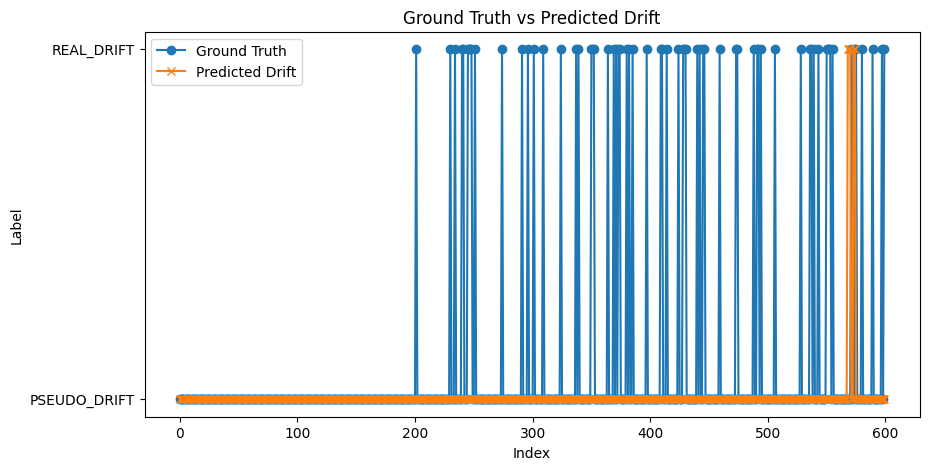

In [ ]:
import matplotlib.pyplot as plt
y_true = df_accuracies["Ground truth"][:]
y_pred = df_summary["final_drift"][:]
plt.figure(figsize=(10,5))
plt.plot(y_true.values, label="Ground Truth", marker='o')
plt.plot(y_pred.values, label="Predicted Drift", marker='x')
plt.xlabel("Index")
plt.ylabel("Label")
plt.title("Ground Truth vs Predicted Drift")
plt.legend()
plt.show()

0.7

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = df_accuracies["Ground truth"][:]
y_pred = df_summary["final_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.885
F1 Score: 0.8387053231701993
Precision: 0.8147731092436975
Recall: 0.885
Confusion Matrix:
 [[530   4]
 [ 65   1]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.89      0.99      0.94       534
  REAL_DRIFT       0.20      0.02      0.03        66

    accuracy                           0.89       600
   macro avg       0.55      0.50      0.48       600
weighted avg       0.81      0.89      0.84       600



0.5

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = df_accuracies["Ground truth"][:]
y_pred = df_summary["final_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.885
F1 Score: 0.8415376013419067
Precision: 0.8253746085280655
Recall: 0.885
Confusion Matrix:
 [[529   5]
 [ 64   2]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.89      0.99      0.94       534
  REAL_DRIFT       0.29      0.03      0.05        66

    accuracy                           0.89       600
   macro avg       0.59      0.51      0.50       600
weighted avg       0.83      0.89      0.84       600



0.3

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = df_accuracies["Ground truth"][:]
y_pred = df_summary["final_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.8866666666666667
F1 Score: 0.8640747135457542
Precision: 0.8570410077727151
Recall: 0.8866666666666667
Confusion Matrix:
 [[520  14]
 [ 54  12]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.91      0.97      0.94       534
  REAL_DRIFT       0.46      0.18      0.26        66

    accuracy                           0.89       600
   macro avg       0.68      0.58      0.60       600
weighted avg       0.86      0.89      0.86       600



In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
df_all.to_csv("/content/drive/My Drive/Early Drift Detection/Drifted_air_data.csv", index=False)

Mounted at /content/drive


**ADWIN Weather**
---

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
# Define the paths to your datasets in Google Drive
import numpy as np
df_all=pd.read_csv("/content/drive/My Drive/Early Drift Detection/Drifted_air_data.csv")
df_all

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Year,Month,DayOfWeek,CRSElapsedTime,Distance,origin_lat,origin_long,dest_lat,dest_long,CRSDepTime_min,total_delay,drift_type,block
0,2000.0,7.0,1.0,56.0,224.0,47.619856,-117.533843,47.448982,-122.309313,510.0,0,sudden_type1,0
1,1999.0,1.0,6.0,60.0,224.0,47.619856,-117.533843,47.448982,-122.309313,630.0,1,sudden_type1,0
2,2000.0,5.0,1.0,55.0,224.0,47.619856,-117.533843,47.448982,-122.309313,1040.0,1,sudden_type1,0
3,1999.0,4.0,3.0,55.0,224.0,47.619856,-117.533843,47.448982,-122.309313,795.0,0,sudden_type1,0
4,1999.0,10.0,5.0,58.0,224.0,47.619856,-117.533843,47.448982,-122.309313,420.0,0,sudden_type1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29962,2000.0,10.0,7.0,44.0,183.0,64.512202,-165.445246,66.884677,-162.598550,506.0,0,recurrent,2996
29963,1999.0,2.0,1.0,37.0,95.0,58.354962,-134.576276,57.047138,-135.361598,610.0,1,recurrent,2996
29964,1999.0,7.0,5.0,28.0,45.0,18.337306,-64.973361,17.701889,-64.798556,880.0,0,recurrent,2996
29965,2000.0,1.0,5.0,36.0,82.0,55.355569,-131.713740,56.484326,-132.369824,617.0,0,recurrent,2996


In [ ]:
import numpy as np
import pandas as pd

# ==========================================================
# VARIANCE-AWARE ADWIN DRIFT DETECTOR
# ==========================================================
def adwin_detector_single_feature(data_stream, delta=0.002, min_window=10):
    """
    ADWIN for single feature — variance-aware.
    Returns drift scores (0–1) combining mean + variance shift effects.
    """
    window = []
    drift_scores = np.zeros(len(data_stream))

    for i, value in enumerate(data_stream):
        window.append(value)

        if len(window) < min_window:
            continue

        n = len(window)
        split_points = [int(0.3 * n), int(0.5 * n), int(0.7 * n)]
        max_drift_score = 0

        for split_point in split_points:
            if split_point < 5 or (n - split_point) < 5:
                continue

            w0 = np.array(window[:split_point])
            w1 = np.array(window[split_point:])

            n0, n1 = len(w0), len(w1)
            m = 1.0 / (1.0 / n0 + 1.0 / n1)

            mean0, mean1 = np.mean(w0), np.mean(w1)
            var0, var1 = np.var(w0), np.var(w1)

            pooled_var = ((n0 - 1) * var0 + (n1 - 1) * var1) / max((n0 + n1 - 2), 1)
            δ_prime = max(delta / n, 1e-12)
            log_term = np.log(2.0 / δ_prime)

            eps_var = np.sqrt((2.0 / m) * pooled_var * log_term) + (2.0 / (3.0 * m)) * log_term

            # components
            mean_diff = abs(mean0 - mean1)
            var_diff = abs(np.sqrt(var0 + 1e-12) - np.sqrt(var1 + 1e-12))

            drift_mag = np.sqrt(mean_diff**2 + var_diff**2)

            drift_score = min(1.0, drift_mag / (eps_var + 1e-8))
            max_drift_score = max(max_drift_score, drift_score)

            # adaptive window shrink
            if drift_score > 0.7:
                window = w1.tolist()
                break

        drift_scores[i] = max_drift_score

        # rolling window control
        if len(window) > 50:
            window = window[-25:]

    return drift_scores


def _minmax_scale_dict(value_dict):
    """Scale dict values to [0,1] with min–max; handle degenerate case."""
    vals = np.array(list(value_dict.values()), dtype=float)
    vmin, vmax = float(np.min(vals)), float(np.max(vals))
    denom = vmax - vmin
    if denom <= 1e-12:
        return {k: 0.0 for k in value_dict}  # all equal
    return {k: (v - vmin) / denom for k, v in value_dict.items()}


# ==================== BLOCKWISE COMBINATION (ADWIN ONLY) ====================
def combine_adwin_drift_scores_blockwise(
    df,
    adwin_scores_dict,
    adwin_threshold=0.6,
    block_size=5,
    use_scaled_threshold=True,
):
    """
    Combine ADWIN drift scores from all features using block averages.
    1) Compute raw block means of ADWIN scores (per block, across features)
    2) Min–max scale block means to [0,1]
    3) Classify each block using the SCALED mean vs adwin_threshold (if use_scaled_threshold=True)
    """
    df = df.copy()
    if "block" not in df.columns:
        raise KeyError("Input DataFrame must contain a 'block' column.")

    df["block_group"] = (df["block"] // block_size).astype(int)

    adwin_block_means = {}

    # First pass: compute raw block means
    for group_id, group_df in df.groupby("block_group"):
        idx = group_df.index
        # mean over features, each feature mean over indices in this block
        per_feature_means = [np.mean(adwin_scores_dict[col][idx]) for col in adwin_scores_dict]
        adwin_block_means[group_id] = float(np.mean(per_feature_means))

    # Second pass: scale raw means to [0,1]
    adwin_block_means_scaled = _minmax_scale_dict(adwin_block_means)

    # Choose which value to compare to threshold
    if use_scaled_threshold:
        label_source = adwin_block_means_scaled
        print("\n=== BLOCK-WISE ADWIN MEAN SCORES (scaled to [0,1]) ===")
    else:
        label_source = adwin_block_means
        print("\n=== BLOCK-WISE ADWIN MEAN SCORES (raw) ===")

    adwin_block_labels = {}
    for gid in sorted(adwin_block_means.keys()):
        raw_mean = adwin_block_means[gid]
        scaled_mean = adwin_block_means_scaled[gid]
        score_for_threshold = label_source[gid]

        label = "REAL_DRIFT" if score_for_threshold > adwin_threshold else "PSEUDO_DRIFT"
        adwin_block_labels[gid] = label

        print(
            f"Block {gid:3d}: Raw={raw_mean:.4f}  Scaled={scaled_mean:.4f}  "
            f"→ Using {'Scaled' if use_scaled_threshold else 'Raw'}={score_for_threshold:.4f}  → {label}"
        )

    # Map results to dataframe
    df["ADWIN_score_mean"] = df["block_group"].map(adwin_block_means)
    df["ADWIN_score_mean_scaled"] = df["block_group"].map(adwin_block_means_scaled)
    df["ADWIN_drift"] = df["block_group"].map(adwin_block_labels)

    return df


# ==================== MAIN FUNCTION ====================
def detect_adwin_drift_all_columns(
    df,
    feature_columns=None,
    adwin_threshold=0.6,
    block_size=5,
    use_scaled_threshold=True,
):
    """
    Detect ADWIN drift on all specified columns with block averaging.
    Block means are min–max scaled to [0,1] and the scaled scores are used for thresholding by default.
    """
    if feature_columns is None:
        exclude_cols = ['activity', 'drift_type', 'block']
        feature_columns = [
            col for col in df.columns
            if col not in exclude_cols and pd.api.types.is_numeric_dtype(df[col])
        ]

    print(f"Processing {len(feature_columns)} features: {feature_columns}")

    adwin_scores_dict = {}
    for col in feature_columns:
        print(f"Calculating ADWIN drift scores for {col}...")
        data = df[col].values
        adwin_scores_dict[col] = adwin_detector_single_feature(data)

    print("\nCombining ADWIN drift scores block-wise (with scaling)...")
    result_df = combine_adwin_drift_scores_blockwise(
        df.copy(),
        adwin_scores_dict,
        adwin_threshold=adwin_threshold,
        block_size=block_size,
        use_scaled_threshold=use_scaled_threshold,
    )

    adwin_real = (result_df['ADWIN_drift'] == 'REAL_DRIFT').sum()
    adwin_pseudo = (result_df['ADWIN_drift'] == 'PSEUDO_DRIFT').sum()

    print(f"\n=== ADWIN DRIFT DETECTION SUMMARY ===")
    print(f"REAL_DRIFT blocks: {adwin_real}")
    print(f"PSEUDO_DRIFT blocks: {adwin_pseudo}")
    print(f"Total blocks: {result_df['block_group'].nunique()}")

    return result_df


# ==================== SIMPLE USAGE ====================
def run_adwin_drift_detection(
    df_all,
    adwin_threshold=0.20,
    block_size=5,
    use_scaled_threshold=True,
):
    return detect_adwin_drift_all_columns(
        df_all,
        adwin_threshold=adwin_threshold,
        block_size=block_size,
        use_scaled_threshold=use_scaled_threshold,
    )

In [ ]:
df_all.columns

Index(['Year', 'Month', 'DayOfWeek', 'CRSElapsedTime', 'Distance',
       'origin_lat', 'origin_long', 'dest_lat', 'dest_long', 'CRSDepTime_min',
       'total_delay', 'drift_type', 'block'],
      dtype='object')

In [ ]:
# ==================== RUN ADWIN DRIFT DETECTION ====================
result = detect_adwin_drift_all_columns(
    df_all,
    feature_columns=[
         "Year",
    "Month",
    "DayOfWeek",
    "CRSElapsedTime",
    "Distance",
    "origin_lat",
    "origin_long",
    "dest_lat",
    "dest_long",
    "CRSDepTime_min"],
    adwin_threshold=0.60,  # threshold applied on scaled mean by default
    block_size=5,
    use_scaled_threshold=True  # ensures scaled values are used
)




# ==================== ANALYZE RESULTS ====================
print("\n--- Drift Counts ---")
print(result['ADWIN_drift'].value_counts())

# Inspect both raw and scaled block mean scores
print("\n--- Block Mean and Scaled Scores ---")
print(
    result[['block_group', 'ADWIN_score_mean', 'ADWIN_score_mean_scaled', 'ADWIN_drift']]
    .drop_duplicates()
    .head(20)
)

# ==================== SAVE RESULTS ====================
result.to_csv('adwin_drift_detection_results.csv', index=False)


Processing 10 features: ['Year', 'Month', 'DayOfWeek', 'CRSElapsedTime', 'Distance', 'origin_lat', 'origin_long', 'dest_lat', 'dest_long', 'CRSDepTime_min']
Calculating ADWIN drift scores for Year...
Calculating ADWIN drift scores for Month...
Calculating ADWIN drift scores for DayOfWeek...
Calculating ADWIN drift scores for CRSElapsedTime...
Calculating ADWIN drift scores for Distance...
Calculating ADWIN drift scores for origin_lat...
Calculating ADWIN drift scores for origin_long...
Calculating ADWIN drift scores for dest_lat...
Calculating ADWIN drift scores for dest_long...
Calculating ADWIN drift scores for CRSDepTime_min...

Combining ADWIN drift scores block-wise (with scaling)...

=== BLOCK-WISE ADWIN MEAN SCORES (scaled to [0,1]) ===
Block   0: Raw=0.1974  Scaled=0.0762  → Using Scaled=0.0762  → PSEUDO_DRIFT
Block   1: Raw=0.2184  Scaled=0.1716  → Using Scaled=0.1716  → PSEUDO_DRIFT
Block   2: Raw=0.2248  Scaled=0.2006  → Using Scaled=0.2006  → PSEUDO_DRIFT
Block   3: Raw=0.2

<Axes: >

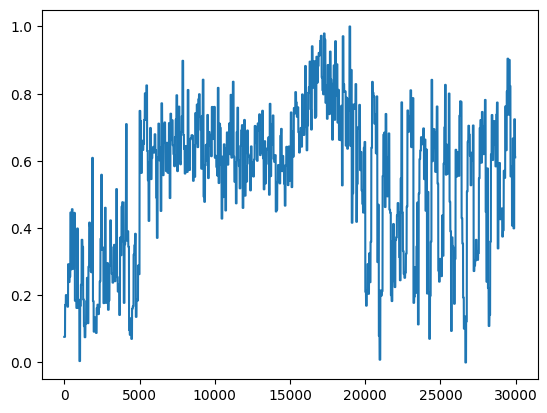

In [ ]:
result['ADWIN_score_mean_scaled'].plot()

In [ ]:
result['ADWIN_drift'].value_counts()

,count
ADWIN_drift,
PSEUDO_DRIFT,15100
REAL_DRIFT,14867


In [ ]:
def majority_drift(series):
    counts = series.value_counts()
    return counts.idxmax() if not counts.empty else "NO_DATA"
# Step 3: Aggregate per block_group
agg_results = result.groupby("block_group").agg({
    "ADWIN_drift": majority_drift
}).reset_index()
# Step 4: Add block range string
agg_results["block_range"] = agg_results["block_group"].apply(lambda g: f"{g*5}-{g*5+4}")
agg_results

,block_group,ADWIN_drift,block_range
0,0,PSEUDO_DRIFT,0-4
1,1,PSEUDO_DRIFT,5-9
2,2,PSEUDO_DRIFT,10-14
3,3,PSEUDO_DRIFT,15-19
4,4,PSEUDO_DRIFT,20-24
...,...,...,...
595,595,PSEUDO_DRIFT,2975-2979
596,596,REAL_DRIFT,2980-2984
597,597,PSEUDO_DRIFT,2985-2989
598,598,REAL_DRIFT,2990-2994


In [ ]:
df_accuracies = pd.read_csv("/content/air_blockwise_accuracies.csv")
df_accuracies["Ground truth"] = np.where(df_accuracies["accuracy"] > 0.60, "PSEUDO_DRIFT", "REAL_DRIFT")
df_accuracies

,block_range,total_blocks,n_samples,accuracy,Ground truth
0,0-4,5,50,0.860000,PSEUDO_DRIFT
1,5-9,5,50,0.920000,PSEUDO_DRIFT
2,10-14,5,50,0.900000,PSEUDO_DRIFT
3,15-19,5,50,0.880000,PSEUDO_DRIFT
4,20-24,5,50,0.960000,PSEUDO_DRIFT
...,...,...,...,...,...
595,2975-2979,5,50,0.520000,REAL_DRIFT
596,2980-2984,5,50,0.700000,PSEUDO_DRIFT
597,2985-2989,5,50,0.500000,REAL_DRIFT
598,2990-2994,5,50,0.520000,REAL_DRIFT


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = df_accuracies["Ground truth"][:]
y_pred = agg_results["ADWIN_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.5916666666666667
F1 Score: 0.6040755068414643
Precision: 0.6492579299820733
Recall: 0.5916666666666667
Confusion Matrix:
 [[230 173]
 [ 72 125]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.76      0.57      0.65       403
  REAL_DRIFT       0.42      0.63      0.51       197

    accuracy                           0.59       600
   macro avg       0.59      0.60      0.58       600
weighted avg       0.65      0.59      0.60       600



***MMD DETECTOR WEATHER***
---

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# ==================== MMD DETECTOR (SINGLE FEATURE) ====================
def mmd_detector_single_feature(data_stream, window_size=20):
    """
    MMD for single feature - returns drift scores (0-1)
    """
    def rbf_kernel(x, y, sigma=1.0):
        x = np.array(x).reshape(-1, 1)
        y = np.array(y).reshape(-1, 1)
        dist_sq = np.sum(x**2, axis=1, keepdims=True) + np.sum(y**2, axis=1) - 2 * (x @ y.T)
        return np.exp(-dist_sq / (2 * sigma**2))

    reference = []
    current = []
    drift_scores = np.zeros(len(data_stream))

    for i, value in enumerate(data_stream):
        current.append(value)

        if len(current) > window_size:
            current = current[-window_size:]

        if len(reference) < window_size:
            reference.append(value)
            continue

        # Compute kernel matrices
        K_ref = rbf_kernel(reference, reference)
        K_curr = rbf_kernel(current, current)
        K_cross = rbf_kernel(reference, current)

        m, n = len(reference), len(current)

        mmd_sq = (np.sum(K_ref) - np.trace(K_ref)) / (m*(m-1)) + \
                 (np.sum(K_curr) - np.trace(K_curr)) / (n*(n-1)) - \
                 2 * np.mean(K_cross)

        mmd_sq = max(0, mmd_sq)
        drift_score = min(1.0, mmd_sq * 10)
        drift_scores[i] = drift_score

        # Update reference window when strong drift detected
        if drift_score > 0.8:
            reference = current.copy()

    return drift_scores


# ==================== COMBINE MMD DRIFT SCORES BLOCKWISE ====================
def combine_mmd_drift_scores_blockwise(df, mmd_scores_dict, mmd_threshold=0.7, block_size=5):
    """
    Combine MMD drift scores from all features using block averages (scaled 0–1).
    """
    df["block_group"] = (df["block"] // block_size).astype(int)
    mmd_block_means = []

    # Compute average drift score per block across all features
    for group_id, group_df in df.groupby("block_group"):
        idx = group_df.index
        mean_score = np.mean([np.mean(mmd_scores_dict[col][idx]) for col in mmd_scores_dict])
        mmd_block_means.append((group_id, mean_score))

    # Convert to DataFrame for scaling
    mmd_block_df = pd.DataFrame(mmd_block_means, columns=["block_group", "MMD_score_mean"])

    # --- Scale block means between 0 and 1 ---
    scaler = MinMaxScaler()
    mmd_block_df["MMD_score_mean_scaled"] = scaler.fit_transform(
        mmd_block_df[["MMD_score_mean"]]
    )

    # --- Classify scaled means ---
    mmd_block_df["MMD_drift"] = np.where(
        mmd_block_df["MMD_score_mean_scaled"] > mmd_threshold,
        "real_drift",
        "pseudo_drift"
    )

    # Merge results back into original DataFrame
    df = df.merge(mmd_block_df, on="block_group", how="left")

    return df


# ==================== MAIN FUNCTION ====================
def detect_mmd_drift_all_columns(df, feature_columns=None, mmd_threshold=0.7, block_size=5):
    """
    Detect drift on all numeric columns using MMD-based scoring.
    """
    if feature_columns is None:
        exclude_cols = ['activity', 'drift_type', 'block']
        feature_columns = [col for col in df.columns if col not in exclude_cols and
                          pd.api.types.is_numeric_dtype(df[col])]

    print(f"Processing {len(feature_columns)} features: {feature_columns}")

    mmd_scores_dict = {}

    for col in feature_columns:
        print(f"Calculating MMD drift scores for {col}...")
        data = df[col].values
        mmd_scores_dict[col] = mmd_detector_single_feature(data)

    print("Combining MMD drift scores block-wise...")
    result_df = combine_mmd_drift_scores_blockwise(df.copy(), mmd_scores_dict,
                                                   mmd_threshold, block_size)

    # Summary
    mmd_real = (result_df['MMD_drift'] == 'real_drift').sum()
    mmd_pseudo = (result_df['MMD_drift'] == 'pseudo_drift').sum()

    print("\n=== MMD DRIFT DETECTION SUMMARY ===")
    print(f"Real drifts: {mmd_real}")
    print(f"Pseudo drifts: {mmd_pseudo}")
    print(f"Total blocks: {result_df['block_group'].nunique()}")

    return result_df


# ==================== SIMPLE USAGE ====================
def run_mmd_drift_detection(df):
    return detect_mmd_drift_all_columns(df)


In [ ]:
# ==================== RUN MMD DRIFT DETECTION ====================
result = detect_mmd_drift_all_columns(
    df_all,
    feature_columns=[
         "Year",
    "Month",
    "DayOfWeek",
    "CRSElapsedTime",
    "Distance",
    "origin_lat",
    "origin_long",
    "dest_lat",
    "dest_long",
    "CRSDepTime_min"
    ],
    mmd_threshold=0.60,  # threshold is applied on the *scaled* [0,1] means
    block_size=5
)
# ==================== ANALYZE RESULTS ====================
print("\n--- Drift Counts ---")
print(result['MMD_drift'].value_counts())

# Show one row per block with both raw and scaled means
block_summary = (
    result[['block_group', 'MMD_score_mean', 'MMD_score_mean_scaled', 'MMD_drift']]
    .drop_duplicates()
    .sort_values('block_group')
)
print("\n--- Block Means (raw & scaled) ---")
print(block_summary.head(20))

Processing 10 features: ['Year', 'Month', 'DayOfWeek', 'CRSElapsedTime', 'Distance', 'origin_lat', 'origin_long', 'dest_lat', 'dest_long', 'CRSDepTime_min']
Calculating MMD drift scores for Year...
Calculating MMD drift scores for Month...
Calculating MMD drift scores for DayOfWeek...
Calculating MMD drift scores for CRSElapsedTime...
Calculating MMD drift scores for Distance...
Calculating MMD drift scores for origin_lat...
Calculating MMD drift scores for origin_long...
Calculating MMD drift scores for dest_lat...
Calculating MMD drift scores for dest_long...
Calculating MMD drift scores for CRSDepTime_min...
Combining MMD drift scores block-wise...

=== MMD DRIFT DETECTION SUMMARY ===
Real drifts: 4867
Pseudo drifts: 25100
Total blocks: 600

--- Drift Counts ---
MMD_drift
pseudo_drift    25100
real_drift       4867
Name: count, dtype: int64

--- Block Means (raw & scaled) ---
     block_group  MMD_score_mean  MMD_score_mean_scaled     MMD_drift
0              0        0.063081      

<Axes: >

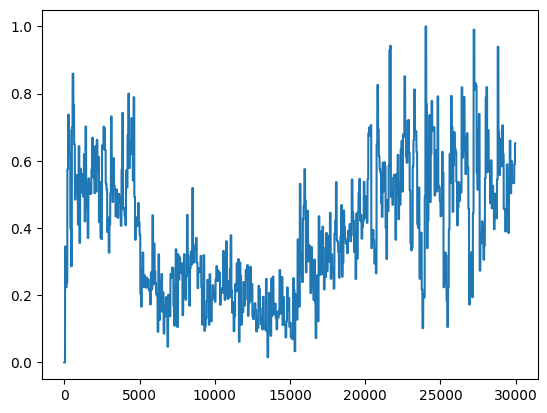

In [ ]:
result['MMD_score_mean_scaled'].plot()

In [ ]:
result['MMD_drift'].value_counts()

,count
MMD_drift,
pseudo_drift,25100
real_drift,4867


In [ ]:
result

,Year,Month,DayOfWeek,CRSElapsedTime,Distance,origin_lat,origin_long,dest_lat,dest_long,CRSDepTime_min,total_delay,drift_type,block,block_group,MMD_score_mean,MMD_score_mean_scaled,MMD_drift
0,2000.0,7.0,1.0,56.0,224.0,47.619856,-117.533843,47.448982,-122.309313,510.0,0,sudden_type1,0,0,0.063081,0.000000,pseudo_drift
1,1999.0,1.0,6.0,60.0,224.0,47.619856,-117.533843,47.448982,-122.309313,630.0,1,sudden_type1,0,0,0.063081,0.000000,pseudo_drift
2,2000.0,5.0,1.0,55.0,224.0,47.619856,-117.533843,47.448982,-122.309313,1040.0,1,sudden_type1,0,0,0.063081,0.000000,pseudo_drift
3,1999.0,4.0,3.0,55.0,224.0,47.619856,-117.533843,47.448982,-122.309313,795.0,0,sudden_type1,0,0,0.063081,0.000000,pseudo_drift
4,1999.0,10.0,5.0,58.0,224.0,47.619856,-117.533843,47.448982,-122.309313,420.0,0,sudden_type1,0,0,0.063081,0.000000,pseudo_drift
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29962,2000.0,10.0,7.0,44.0,183.0,64.512202,-165.445246,66.884677,-162.598550,506.0,0,recurrent,2996,599,0.231840,0.652542,real_drift
29963,1999.0,2.0,1.0,37.0,95.0,58.354962,-134.576276,57.047138,-135.361598,610.0,1,recurrent,2996,599,0.231840,0.652542,real_drift
29964,1999.0,7.0,5.0,28.0,45.0,18.337306,-64.973361,17.701889,-64.798556,880.0,0,recurrent,2996,599,0.231840,0.652542,real_drift
29965,2000.0,1.0,5.0,36.0,82.0,55.355569,-131.713740,56.484326,-132.369824,617.0,0,recurrent,2996,599,0.231840,0.652542,real_drift


In [ ]:
def majority_drift(series):
    counts = series.value_counts()
    return counts.idxmax() if not counts.empty else "NO_DATA"
# Step 3: Aggregate per block_group
agg_results = result.groupby("block_group").agg({
    "MMD_drift": majority_drift
}).reset_index()
agg_results["block_range"] = agg_results["block_group"].apply(lambda g: f"{g*5}-{g*5+4}")
agg_results

,block_group,MMD_drift,block_range
0,0,pseudo_drift,0-4
1,1,pseudo_drift,5-9
2,2,pseudo_drift,10-14
3,3,pseudo_drift,15-19
4,4,pseudo_drift,20-24
...,...,...,...
595,595,pseudo_drift,2975-2979
596,596,pseudo_drift,2980-2984
597,597,pseudo_drift,2985-2989
598,598,pseudo_drift,2990-2994


In [ ]:
agg_results["MMD_drift"] = agg_results["MMD_drift"].replace("pseudo_drift", "PSEUDO_DRIFT")
agg_results["MMD_drift"] = agg_results["MMD_drift"].replace("real_drift", "REAL_DRIFT")

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = df_accuracies["Ground truth"][:]
y_pred = agg_results["MMD_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.5816666666666667
F1 Score: 0.5343529668820427
Precision: 0.5112274033119223
Recall: 0.5816666666666667
Confusion Matrix:
 [[327  76]
 [175  22]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.65      0.81      0.72       403
  REAL_DRIFT       0.22      0.11      0.15       197

    accuracy                           0.58       600
   macro avg       0.44      0.46      0.44       600
weighted avg       0.51      0.58      0.53       600



**D3**
---

In [ ]:
import numpy as np
import pandas as pd

def make_blockgroup_features(df, feature_columns, block_size=5):
    df = df.copy()
    df["block_group"] = (df["block"] // block_size).astype(int)

    # One vector per block_group (mean per sensor axis)
    X_bg = (
        df.groupby("block_group")[feature_columns]
          .mean()
          .reset_index()
          .sort_values("block_group")
          .reset_index(drop=True)
    )
    return X_bg  # columns: block_group + 6 sensor means


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

def d3_detector_multifeature(X_stream, w=20, rho=0.2, tau=0.7):
    """
    X_stream: numpy array shape (T, d)
    returns:
      drift_flags: array length T (True/False)
      auc_scores:  array length T (float)
    """
    T = X_stream.shape[0]
    new_size = max(2, int(w * rho))     # must be >=2 for stable AUC
    old_size = w

    drift_flags = np.zeros(T, dtype=bool)
    auc_scores  = np.zeros(T, dtype=float)

    # rolling reference index update (matches D3 idea: when drift -> advance faster)
    start = 0
    while True:
        end = start + old_size + new_size
        if end > T:
            break

        old = X_stream[start : start + old_size]
        new = X_stream[start + old_size : end]

        X = np.vstack([old, new])
        s = np.hstack([np.zeros(old.shape[0]), np.ones(new.shape[0])])

        # scale inside the window (important for HAR axes)
        scaler = StandardScaler()
        Xs = scaler.fit_transform(X)

        clf = LogisticRegression(max_iter=200, solver="lbfgs")
        clf.fit(Xs, s)

        # AUC on the same window (baseline style; you can add CV later if you want)
        probs = clf.predict_proba(Xs)[:, 1]
        auc = roc_auc_score(s, probs)

        # write score at the last index of the new window (decision time)
        decision_t = end - 1
        auc_scores[decision_t] = auc
        drift_flags[decision_t] = (auc >= tau)

        # D3-style window shift: if drift, drop w; else drop w*rho
        if drift_flags[decision_t]:
            start = start + old_size
        else:
            start = start + new_size

    return drift_flags, auc_scores


In [ ]:
def run_d3_baseline(df_all, feature_columns, block_size=5, w=20, rho=0.2, tau=0.7):
    # Step A: build block_group feature stream
    X_bg = make_blockgroup_features(df_all, feature_columns, block_size=block_size)
    X_stream = X_bg[feature_columns].values
    drift_flags, auc_scores = d3_detector_multifeature(X_stream, w=w, rho=rho, tau=tau)
    # Step B: convert to your labels at block_group level
    pred = np.where(drift_flags, "REAL_DRIFT", "PSEUDO_DRIFT")
    agg_results = pd.DataFrame({
        "block_group": X_bg["block_group"].values,
        "D3_AUC": auc_scores,
        "D3_drift": pred
    })
    # Optional: create block_range like you did
    agg_results["block_range"] = agg_results["block_group"].apply(
        lambda g: f"{g*block_size}-{g*block_size+(block_size-1)}"
    )
    return agg_results

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
#df_accuracies = pd.read_csv("/content/Ground.csv")
y_true = df_accuracies["Ground truth"].values
agg_results_d3 = run_d3_baseline(
    df_all,
    feature_columns=[
              "Year",
    "Month",
    "DayOfWeek",
    "CRSElapsedTime",
    "Distance",
    "origin_lat",
    "origin_long",
    "dest_lat",
    "dest_long",
    "CRSDepTime_min"
    ],
    block_size=5,
    w=20, rho=0.2, tau=0.4
)
y_pred = agg_results_d3["D3_drift"].values
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred, average="weighted"))
print("Precision:", precision_score(y_true, y_pred, average="weighted"))
print("Recall:", recall_score(y_true, y_pred, average="weighted"))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))


Accuracy: 0.64
F1 Score: 0.5372419181915647
Precision: 0.5024264750286853
Recall: 0.64
Confusion Matrix:
 [[379  24]
 [192   5]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.66      0.94      0.78       403
  REAL_DRIFT       0.17      0.03      0.04       197

    accuracy                           0.64       600
   macro avg       0.42      0.48      0.41       600
weighted avg       0.50      0.64      0.54       600



**STUUD**
---

In [ ]:
# ============================================================
# CELL 1: AIR – Load/Clean/Engineer + TEACHER RF
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# ============================================================
# Step 0: Load Dataset
# ============================================================

df = pd.read_csv("/content/air_2019.csv")
df.columns = [c.strip() for c in df.columns]

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

df = df.dropna().reset_index(drop=True)

# Ensure block exists (needed for blockwise aggregation later)
if "block" not in df.columns:
    df["block"] = np.arange(len(df))

# ============================================================
# Step 1: Time Feature Engineering (HHMM -> minutes)
# ============================================================

def hhmm_to_minutes(x):
    x = int(x)
    hh = x // 100
    mm = x % 100
    if mm >= 60:
        mm = 59
    return hh * 60 + mm

for col in ["CRSDepTime", "CRSArrTime"]:
    if col in df.columns:
        df[col + "_min"] = df[col].apply(hhmm_to_minutes)

drop_time_cols = [c for c in ["CRSDepTime", "CRSArrTime"] if c in df.columns]
if len(drop_time_cols) > 0:
    df = df.drop(columns=drop_time_cols)

# ============================================================
# Step 2: Define feature_columns and Target
# ============================================================

feature_columns = [
    "Year",
    "Month",
    "DayOfWeek",
    "CRSElapsedTime",
    "Distance",
    "origin_lat",
    "origin_long",
    "dest_lat",
    "dest_long",
    "CRSDepTime_min",
    # "CRSArrTime_min",
]

target_col = "total_delay"
feature_columns = [c for c in feature_columns if c in df.columns]

# ============================================================
# Step 3: Select Features (X) and Target (y)
# ============================================================

X = df[feature_columns].copy()
y = df[target_col].astype(int)

for c in feature_columns:
    if X[c].dtype == "object":
        X[c] = pd.to_numeric(X[c], errors="coerce")

mask = X.notna().all(axis=1)
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

# ============================================================
# Step 4: Train–Test Split (Teacher training)
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# ============================================================
# Step 5: Feature Scaling (kept for same pipeline format)
# ============================================================

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# ============================================================
# Step 6: TEACHER Random Forest
# ============================================================

teacher = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

# ============================================================
# Step 7: Train TEACHER
# ============================================================

teacher.fit(X_train_sc, y_train)

# ============================================================
# Step 8: Evaluate TEACHER
# ============================================================

yT_pred = teacher.predict(X_test_sc)

print("\n✅ TEACHER Confusion Matrix:")
print(confusion_matrix(y_test, yT_pred))

print("\n✅ TEACHER Classification Report:")
print(classification_report(y_test, yT_pred, digits=4))

print("✅ TEACHER Accuracy:", accuracy_score(y_test, yT_pred))



✅ TEACHER Confusion Matrix:
[[1629  258]
 [ 898  212]]

✅ TEACHER Classification Report:
              precision    recall  f1-score   support

           0     0.6446    0.8633    0.7381      1887
           1     0.4511    0.1910    0.2684      1110

    accuracy                         0.6143      2997
   macro avg     0.5479    0.5271    0.5032      2997
weighted avg     0.5729    0.6143    0.5641      2997

✅ TEACHER Accuracy: 0.614280947614281


In [ ]:
# ============================================================
# CELL 2: AIR – Distillation targets + STUDENT RF (imitation)
# ============================================================

from sklearn.model_selection import train_test_split

# Full stream (same order)
X_all = df[feature_columns].copy()

for c in feature_columns:
    if X_all[c].dtype == "object":
        X_all[c] = pd.to_numeric(X_all[c], errors="coerce")

mask_all = X_all.notna().all(axis=1)
X_all = X_all.loc[mask_all].reset_index(drop=True)

# Align df too (important for later blockwise)
df = df.loc[mask_all].reset_index(drop=True)

X_all_sc = scaler.transform(X_all)

# Teacher soft + hard outputs as distillation targets
teacher_probs_all = teacher.predict_proba(X_all_sc)          # (N,2)
teacher_pseudo_y  = np.argmax(teacher_probs_all, axis=1)     # hard pseudo labels

# Split imitation training
Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    X_all_sc,
    teacher_pseudo_y,
    test_size=0.3,
    random_state=42,
    stratify=teacher_pseudo_y
)

# STUDENT RF (smaller)
student = RandomForestClassifier(
    n_estimators=200,           # smaller than teacher
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

student.fit(Xs_train, ys_train)

# Imitation accuracy (student vs teacher pseudo labels)
ys_pred = student.predict(Xs_test)
imitation_acc = (ys_pred == ys_test).mean()

print("✅ Student imitation accuracy (vs teacher pseudo labels):", imitation_acc)


✅ Student imitation accuracy (vs teacher pseudo labels): 0.7317317317317318


In [ ]:
# ============================================================
# CELL 3: AIR – Disagreement stream (Hard + KL)
# ============================================================

from scipy.special import rel_entr

def per_sample_kl(p, q, eps=1e-12):
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)
    return np.sum(rel_entr(p, q), axis=1)

# Teacher & student probabilities on full stream
T_probs = teacher.predict_proba(X_all_sc)
S_probs = student.predict_proba(X_all_sc)

# (A) Hard disagreement (0/1)
T_hat = np.argmax(T_probs, axis=1)
S_hat = np.argmax(S_probs, axis=1)
loss_stream_error = (T_hat != S_hat).astype(float)

# (B) Soft disagreement (KL)
loss_stream_kl = per_sample_kl(T_probs, S_probs)

print("Example error-loss values:", loss_stream_error[:10])
print("Example KL-loss values:", loss_stream_kl[:10])


Example error-loss values: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Example KL-loss values: [5.47198347e-03 2.58263845e-03 5.27136023e-03 1.13320197e-04
 2.58463780e-01 8.72221133e-03 1.18022579e-02 8.00293504e-04
 1.14589942e-04 2.04216922e-01]


In [ ]:
# ============================================================
# CELL 4: AIR – Blockwise aggregation + Drift labeling
# ============================================================

def blockwise_loss_labels(df_all, loss_stream, block_size=50, threshold=0.3):
    df_tmp = df_all.copy().reset_index(drop=True)
    df_tmp["loss_raw"] = loss_stream

    # Min-Max scale to [0, 1]
    loss_min = df_tmp["loss_raw"].min()
    loss_max = df_tmp["loss_raw"].max()
    if loss_max > loss_min:
        df_tmp["loss"] = (df_tmp["loss_raw"] - loss_min) / (loss_max - loss_min)
    else:
        df_tmp["loss"] = 0.0

    # Ensure block exists
    if "block" not in df_tmp.columns:
        df_tmp["block"] = np.arange(len(df_tmp))

    # block group
    df_tmp["block_group"] = (df_tmp["block"] // block_size).astype(int)

    # aggregate mean loss per group
    bg = (
        df_tmp.groupby("block_group")["loss"]
        .mean()
        .reset_index()
        .sort_values("block_group")
    )

    bg["STTUDD_drift"] = np.where(bg["loss"] > threshold, "REAL_DRIFT", "PSEUDO_DRIFT")
    bg["block_range"] = bg["block_group"].apply(
        lambda g: f"{g*block_size}-{g*block_size+(block_size-1)}"
    )

    return bg

agg_sttudd = blockwise_loss_labels(
    df_all=df,
    loss_stream=loss_stream_kl,   # or loss_stream_error
    block_size=10,
    threshold=0.05
)

print(agg_sttudd.head(20))
print(agg_sttudd["STTUDD_drift"].value_counts())


    block_group      loss  STTUDD_drift block_range
0             0  0.027943  PSEUDO_DRIFT         0-9
1             1  0.020529  PSEUDO_DRIFT       10-19
2             2  0.068263    REAL_DRIFT       20-29
3             3  0.070216    REAL_DRIFT       30-39
4             4  0.087415    REAL_DRIFT       40-49
5             5  0.009395  PSEUDO_DRIFT       50-59
6             6  0.005447  PSEUDO_DRIFT       60-69
7             7  0.059670    REAL_DRIFT       70-79
8             8  0.034334  PSEUDO_DRIFT       80-89
9             9  0.127730    REAL_DRIFT       90-99
10           10  0.024733  PSEUDO_DRIFT     100-109
11           11  0.065202    REAL_DRIFT     110-119
12           12  0.041965  PSEUDO_DRIFT     120-129
13           13  0.083452    REAL_DRIFT     130-139
14           14  0.027784  PSEUDO_DRIFT     140-149
15           15  0.054813    REAL_DRIFT     150-159
16           16  0.055876    REAL_DRIFT     160-169
17           17  0.200077    REAL_DRIFT     170-179
18          

In [ ]:
# ============================================================
# CELL 5: AIR – Evaluate vs Ground truth (optional)
# ============================================================

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

#df_accuracies = pd.read_csv("/content/Ground.csv")

y_true = df_accuracies["Ground truth"].values
y_pred = agg_sttudd["STTUDD_drift"][:600]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred, average="weighted"))
print("Precision:", precision_score(y_true, y_pred, average="weighted"))
print("Recall:", recall_score(y_true, y_pred, average="weighted"))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))


Accuracy: 0.4866666666666667
F1 Score: 0.5004287993992304
Precision: 0.5647690387016229
Recall: 0.4866666666666667
Confusion Matrix:
 [[181 222]
 [ 86 111]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.68      0.45      0.54       403
  REAL_DRIFT       0.33      0.56      0.42       197

    accuracy                           0.49       600
   macro avg       0.51      0.51      0.48       600
weighted avg       0.56      0.49      0.50       600



**Sequential CP-Calibrated C2S**
---

In [ ]:
# ============================================================
# JANG22 SEQUENTIAL CALIBRATED C2ST (COVARIATE SHIFT DETECTOR)
# Full working code: df_all (stream) + df_accuracies (ground truth)
# UPDATED: prints Accuracy + Confusion Matrix + Report automatically
# ============================================================

import numpy as np
import pandas as pd
from collections import deque
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from scipy.stats import beta
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report
)

# ============================================================
# 1) CLOPPER–PEARSON CONFIDENCE INTERVAL
# ============================================================
def clopper_pearson_interval(successes, n, alpha=0.05):
    s = int(successes)

    if s == 0:
        lo = 0.0
    else:
        lo = beta.ppf(alpha / 2, s, n - s + 1)

    if s == n:
        hi = 1.0
    else:
        hi = beta.ppf(1 - alpha / 2, s + 1, n - s)

    return lo, hi


# ============================================================
# 2) SEQUENTIAL C2ST WITH CP CALIBRATION (FAST + FIXED)
# ============================================================
def sequential_c2st_cp(
    df_all,
    feature_columns,
    source_df=None,
    source_size=500,
    w=50,
    alpha=0.05,
    random_state=42,
    check_every=1,
    return_debug=True,
    verbose_every=50000
):
    rng = np.random.default_rng(random_state)

    df_stream = df_all.reset_index(drop=True).copy()

    if source_df is None:
        if source_size >= len(df_stream):
            raise ValueError("source_size must be smaller than len(df_all).")
        source_df = df_stream.iloc[:source_size].copy().reset_index(drop=True)
        target_df = df_stream.iloc[source_size:].copy().reset_index(drop=True)
    else:
        source_df = source_df.copy().reset_index(drop=True)
        target_df = df_stream.copy().reset_index(drop=True)

    X_source = source_df[feature_columns].to_numpy(dtype=np.float32)
    X_target = target_df[feature_columns].to_numpy(dtype=np.float32)

    scaler = StandardScaler()
    scaler.fit(X_source)

    X_source_sc = scaler.transform(X_source).astype(np.float32)
    X_target_sc = scaler.transform(X_target).astype(np.float32)

    clf = SGDClassifier(
        loss="log_loss",
        penalty="l2",
        alpha=1e-4,
        learning_rate="optimal",
        random_state=random_state
    )

    # init
    X_init = np.vstack([X_source_sc[:1], X_target_sc[:1]])
    y_init = np.array([0, 1], dtype=int)
    clf.partial_fit(X_init, y_init, classes=np.array([0, 1], dtype=int))

    correct_window = deque(maxlen=2 * w)

    T = X_target_sc.shape[0]
    cov_shift = np.zeros(T, dtype=np.int8)

    if return_debug:
        mu_hat_arr = np.full(T, np.nan, dtype=np.float32)
        lo_arr     = np.full(T, np.nan, dtype=np.float32)
        hi_arr     = np.full(T, np.nan, dtype=np.float32)

    for t in range(T):
        s_idx = rng.integers(0, X_source_sc.shape[0])
        x_s = X_source_sc[s_idx:s_idx+1]
        x_t = X_target_sc[t:t+1]

        yhat_s = int(clf.predict(x_s)[0])
        yhat_t = int(clf.predict(x_t)[0])

        z_s = 1 if yhat_s == 0 else 0
        z_t = 1 if yhat_t == 1 else 0

        correct_window.append(z_s)
        correct_window.append(z_t)

        if len(correct_window) == 2 * w and (t % check_every == 0):
            successes = int(np.sum(correct_window))
            n = 2 * w
            mu_hat = successes / n
            lo, hi = clopper_pearson_interval(successes, n, alpha=alpha)

            cov_shift[t] = 1 if not (lo <= 0.5 <= hi) else 0

            if return_debug:
                mu_hat_arr[t] = mu_hat
                lo_arr[t] = lo
                hi_arr[t] = hi

        clf.partial_fit(np.vstack([x_s, x_t]), np.array([0, 1], dtype=int))

        if verbose_every and ((t + 1) % verbose_every == 0):
            print(f"Processed {t+1}/{T} target steps...")

    out = pd.DataFrame({"t": np.arange(T), "cov_shift": cov_shift})

    if return_debug:
        out["mu_hat"] = mu_hat_arr
        out["cp_lo"] = lo_arr
        out["cp_hi"] = hi_arr

    return out


# ============================================================
# 3) EVALUATION (AUTO PRINT METRICS + CONFUSION MATRIX)
# ============================================================
def evaluate_shift_detection(pred_df, df_accuracies, gt_col="Ground truth", pred_col="cov_shift"):
    """
    Prints Accuracy, Precision, Recall, F1, Confusion Matrix, Report.
    Handles both numeric 0/1 and string labels in ground truth.
    """

    y_pred = pred_df[pred_col].values

    # ----- Ground truth -----
    y_true_raw = df_accuracies[gt_col].values

    # Map GT strings -> 0/1 if needed
    if y_true_raw.dtype == object:
        mapping = {
            "REAL_DRIFT": 1, "PSEUDO_DRIFT": 0,
            "real_drift": 1, "pseudo_drift": 0,
            "SHIFT": 1, "NO_SHIFT": 0,
            "DRIFT": 1, "NO_DRIFT": 0,
            "1": 1, "0": 0
        }
        y_true = np.array([mapping.get(str(v).strip(), v) for v in y_true_raw], dtype=int)
    else:
        y_true = y_true_raw.astype(int)

    # ----- Align length safely -----
    n = min(len(y_true), len(y_pred))
    y_true = y_true[:n]
    y_pred = y_pred[:n]

    # ----- Metrics -----
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="weighted")
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    cm   = confusion_matrix(y_true, y_pred)

    print("\n================= EVALUATION RESULTS =================")
    print("Accuracy :", acc)
    print("F1 Score :", f1)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))
    print("======================================================\n")


# ============================================================
# 4) RUN (EXAMPLE)
# ============================================================
feature_columns = [ "Year",
    "Month",
    "DayOfWeek",
    "CRSElapsedTime",
    "Distance",
    "origin_lat",
    "origin_long",
    "dest_lat",
    "dest_long",
    "CRSDepTime_min"]

# IMPORTANT: alpha should be <= 0.05 typically. alpha=0.5 makes it meaningless.
pred = sequential_c2st_cp(
    df_all=df_all,
    feature_columns=feature_columns,
    source_size=500,
    w=50,
    alpha=0.3,        # ✅ recommended
    check_every=5,
    return_debug=True,
    verbose_every=20000
)
print(pred["cov_shift"].value_counts())
print(pred.head(10))
# ---- Load your ground truth and evaluate ----
#df_accuracies = pd.read_csv("/content/Ground.csv")   # <-- your ground truth file path
evaluate_shift_detection(pred, df_accuracies, gt_col="Ground truth", pred_col="cov_shift")
# ---- Save predictions ----
pred.to_csv("jang22_covariate_shift_predictions.csv", index=False)
print("✅ Saved: jang22_covariate_shift_predictions.csv")

Processed 20000/29467 target steps...
cov_shift
0    23874
1     5593
Name: count, dtype: int64
   t  cov_shift  mu_hat  cp_lo  cp_hi
0  0          0     NaN    NaN    NaN
1  1          0     NaN    NaN    NaN
2  2          0     NaN    NaN    NaN
3  3          0     NaN    NaN    NaN
4  4          0     NaN    NaN    NaN
5  5          0     NaN    NaN    NaN
6  6          0     NaN    NaN    NaN
7  7          0     NaN    NaN    NaN
8  8          0     NaN    NaN    NaN
9  9          0     NaN    NaN    NaN

================= EVALUATION RESULTS =================
Accuracy : 0.6283333333333333
F1 Score : 0.5937751701313023
Precision: 0.5845643166357453
Recall   : 0.6283333333333333

Confusion Matrix:
 [[335  68]
 [155  42]]

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.83      0.75       403
           1       0.38      0.21      0.27       197

    accuracy                           0.63       600
   macro avg       0.53 